# Spatial Weights

## Introduction

Spatial weights are widely used in geographic data science to represent geographical relationships between the observational units in a spatially referenced dataset. By expressing the notion of geographical proximity or connectedness, spatial weights are the main mechansim through which the spatial information in geographical data is brought to bear in the subsequent analysis.

For example, proximity and adjacency are common spatial questions:

    What neighborhoods surround yours?
    How many gas stations are within 5 miles of my stalled car? 

As stated above, these are spatial questions that target specific information about the spatial relationships between a specific target ("your neighborhood," "my stalled car") and surrounding relevant sites ("nearby gas stations," "adjacent neighborhoods"). However, for us to use this information in statistical analysis, it's often necessary to have computed these relationships between all pairs of observations. This means that, for geographic data science, we are building a *topology*---a mathematical structure that expresses the geometric and spatial relationships between observations---that we can use to examine the data. Spatial weights provide this topology, letting us embed all of our observations in space together, rather than asking and answering single questions about your nearby neighborhoods. 

Since they provide a way to represent these spatial relationships, spatial weights are widely utilized throughout spatial and geographic data science.
In what follows, we first consider different approaches to construct spatial weights, distinguishing between those based on contiguity/adjacency relations from weights obtained from distance based relationships. We then discuss the case of hybrid weights which combine one or more spatial operations in deriving the neighbor relationships between observations. We illustrate all of these concepts through the spatial weights class in PySAL which provides a rich set of methods and characteristics for spatial weights. We also demonstrate its functionality regarding set theory, which permits the derivation of weights through application of notions from set theory. Throughout the chapter, we discuss common file formats used to store spatial weights of different types, and we include visual discussion of spatial weights, making these sometimes abstract constructs more intuitive.

In [1]:
%matplotlib inline

from pysal.lib import weights
from pysal.lib import cg as geometry
import geopandas
import seaborn
import pandas 
import numpy
import matplotlib.pyplot as plt
from shapely.geometry import Polygon

/home/serge/anaconda3/envs/gdsbook/lib/python3.6/site-packages/pysal/explore/segregation/network/network.py:16: UserWarning: You need pandana and urbanaccess to work with segregation's network module
You can install them with  `pip install urbanaccess pandana` or `conda install -c udst pandana urbanaccess`
  "You need pandana and urbanaccess to work with segregation's network module\n"


## Contiguity Weights

A contiguous pair of spatial units are those who share a common border. At first
glance this seems straightforward, however, in practice matters turn out to be
no so simple. The first complication is that there are different notions of
contiguity to consider. First, though, let's use a simple example of a three-by-three grid:

In [2]:
# Get points in a grid
l = numpy.arange(3)
xs, ys = numpy.meshgrid(l, l)
# Set up store
polys = []
# Generate polygons
for x, y in zip(xs.flatten(), ys.flatten()):
    poly = Polygon([(x, y), (x+1, y), (x+1, y+1), (x, y+1)])
    polys.append(poly)
# Convert to GeoSeries
polys = geopandas.GeoSeries(polys)
gdf = geopandas.GeoDataFrame({'geometry': polys, 
                        'id': ['P-%s'%str(i).zfill(2) for i in range(len(polys))]})

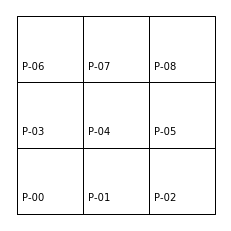

In [3]:
ax = gdf.plot(facecolor='w', edgecolor='k')
[plt.text(x, y, t, 
          verticalalignment='center',
          horizontalalignment='center') for x, y, t in zip(
         [p.centroid.x-.25 for p in polys],
         [p.centroid.y-.25 for p in polys],
         [i for i in gdf['id']])]
ax.set_axis_off()
plt.show()

A common way to express contiguity/adjacency relationships arises from an analogy to the legal moves that different chess pieces can make. *Rook* contiguity requires that the pair of polygons in
question share an *edge*. According to this definition, polygon $0$ would be a rook neighbor of $1$ and $3$, while $1$ would be a rook neighbor with $0$, $2$, and $4$. Applying this rule to all 9 polygons we can model our neighbor relations as:

In [4]:
# do a regular 3x3 lattice and draw it here
w = weights.contiguity.Rook.from_dataframe(gdf)
w.neighbors

{0: [1, 3],
 1: [0, 2, 4],
 2: [1, 5],
 3: [0, 4, 6],
 4: [1, 3, 5, 7],
 5: [8, 2, 4],
 6: [3, 7],
 7: [8, 4, 6],
 8: [5, 7]}

Shown visually, we can see this plotted on top of the same grid of labelled polygons, using red dotted lines showing connetions between the polygons:

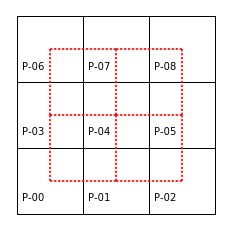

In [5]:
f,ax = plt.subplots(1,1, subplot_kw=dict(aspect='equal'))
w.plot(gdf, edge_kws=dict(color='r', linestyle=':'), ax =ax)
gdf.plot(facecolor='w', edgecolor='k', ax=ax)
[ax.text(x, y, t, 
          verticalalignment='center',
          horizontalalignment='center') for x, y, t in zip(
         [p.centroid.x-.25 for p in polys],
         [p.centroid.y-.25 for p in polys],
         [i for i in gdf['id']])]
plt.gca().set_axis_off()

The  `neighbors` attribute of our PySAL $W$ object encodes the neighbor
relationships by expressing the *focal* observation on the left (in the `key` of the dictionary), and expressing the *neighbors* to the *focal* in the list on the right (in the `value` of the dictionary). This representation has computational advantages as it exploits
the sparse nature of contiguity weights matrices. 

More specifically, knowing
that the neighbors of polygon $0$ are $3$ and $1$ implies that polygons $2, 4,
5, 6, 7, 8$ are not Rook neighbors of 0. As such, there is no reason to store
the "non-neighbor" information and this results in significant reductions in
memory requirements. However, it is possible to create the fully dense
representation if needed:

In [6]:
pandas.DataFrame(*w.full()).astype(int)

,0,1,2,3,4,5,6,7,8
0,0,1,0,1,0,0,0,0,0
1,1,0,1,0,1,0,0,0,0
2,0,1,0,0,0,1,0,0,0
3,1,0,0,0,1,0,1,0,0
4,0,1,0,1,0,1,0,1,0
5,0,0,1,0,1,0,0,0,1
6,0,0,0,1,0,0,0,1,0
7,0,0,0,0,1,0,1,0,1
8,0,0,0,0,0,1,0,1,0


As you can see from the matrix above, most entries are zero. In fact out of all of the possible $9^2=81$ linkages that there could be in this matrix, there are only twenty-four:

In [7]:
w.nonzero

24

Thus, we can save a significant amount of memory and lose no information by storing these sparse representations, which only record the non-zero values. 

More generally, the spatial weights for our 3-by-3 grid can be represented as a matrix that has 9 rows and 9 columns, matching the number of polygons $(n=9)$. An important thing to note is that geography has more than one dimension. When compared to common representations of relationships *in time* used in data science, using information about spatial relationships can be more complex: spatial relationships are bi-directional, while temporal relationships are unidirectional. Further complicating things, the ordering of the observations in the weights matrix is ambiguous. The first row is not first for a specific reason. Here we simply use the alphanumeric ordering of the unit identifiers to match a polygon with a row or column of the matrix, but any arbitrary rule could be followed and the weights matrix would look different. The graph, however, would be isomorphic.. 

Spatial weights matrices may look familiar to those acquainted with social
networks and graph theory in which **adjacency** matrices play a central role in
expressing connectivity between nodes. Indeed, spatial weights matrices can be
understood as a graph adjacency matrix where each observation is a node and
the spatial weight assigned between a pair represents the weight of the edge on
a graph connecting the arcs. Sometimes, this is called the **dual graph** or **line graph** of the input geographic data. This is advantageous as geographic data science can
borrow from the rich graph theory literature. At the same time, spatial
data has numerous distinguishing characteristics that necessitate the
development of specialized procedures and concepts in the handling of spatial
weights. In this chapter we will cover many of these features.

A close inspection of our graph reveals that the Rook contiguity criterion actually places
a restriction on the spatial relation. More specifically, polygons $0$ and $5$
are not Rook neighbors, but they do in fact share a common border. However, in
this instance the sharing is due to a common *vertex* rather than a shared
*edge*. This leads to the more inclusive notion of *Queen* contiguity that
requires the pair of polygons to only share one or more *vertices*. We can create the
neighbor relations for this same configuration as follows:

In [8]:
# do a regular 3x3 lattice and draw it here
w = weights.contiguity.Queen.from_dataframe(gdf)
w.neighbors

{0: [1, 3, 4],
 1: [0, 2, 3, 4, 5],
 2: [1, 4, 5],
 3: [0, 1, 4, 6, 7],
 4: [0, 1, 2, 3, 5, 6, 7, 8],
 5: [1, 2, 4, 7, 8],
 6: [3, 4, 7],
 7: [3, 4, 5, 6, 8],
 8: [4, 5, 7]}

In addition to this neighbors representation, we can also express the graph visually, as done before:

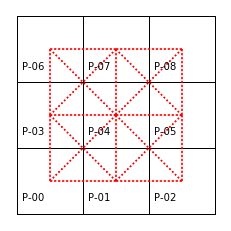

In [9]:
f,ax = plt.subplots(1,1, subplot_kw=dict(aspect='equal'))
w.plot(gdf, edge_kws=dict(color='r', linestyle=':'), ax =ax)
gdf.plot(facecolor='w', edgecolor='k', ax=ax)
[ax.text(x, y, t, 
          verticalalignment='center',
          horizontalalignment='center') for x, y, t in zip(
         [p.centroid.x-.25 for p in polys],
         [p.centroid.y-.25 for p in polys],
         [i for i in gdf['id']])]
plt.gca().set_axis_off()

By using `Contiguity.Queen` rather than `Contiguity.Rook`, we consider observations that share a vertex to be neighbors. The result is that the neighbors of $0$ now include $4$ along with $3$ and $1$.

Like the `neighbors` dictionary encodes the contiguity relations, the `weights` dictionary encodes the strength of the link connecting the focal to each neighbor. For contiguity
weights, values are usually binary and, as in any `PySAL` `W` object, contained in its
`weights` attribute:

In [10]:
w.weights

{0: [1.0, 1.0, 1.0],
 1: [1.0, 1.0, 1.0, 1.0, 1.0],
 2: [1.0, 1.0, 1.0],
 3: [1.0, 1.0, 1.0, 1.0, 1.0],
 4: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 5: [1.0, 1.0, 1.0, 1.0, 1.0],
 6: [1.0, 1.0, 1.0],
 7: [1.0, 1.0, 1.0, 1.0, 1.0],
 8: [1.0, 1.0, 1.0]}

Similar to the `neighbors` attribute, the `weights` object is a Python
dictionary that only stores the non-zero weights. Although the weights for a
given observations neighbors are all the same value for contiguity weights, it
is important to note that the `weights` and `neighbors` are aligned with one another; for each observation, its first neighbor in `neighbors` has the first weight in its `weights` entry. This will be important when we examine distance based weights further
on, when observations will have different weights. 

In addition to the `neighbor` and `weights` attributes, the `w` object has a
large number of other attributes and methods that can be useful. The
`cardinalities` attribute reports the number of neighbors for each observation:

In [11]:
w.cardinalities

{0: 3, 1: 5, 2: 3, 3: 5, 4: 8, 5: 5, 6: 3, 7: 5, 8: 3}

The related `histogram` attribute provides an overview of the distribution of
these cardinalities:

In [12]:
w.histogram

[(3, 4), (4, 0), (5, 4), (6, 0), (7, 0), (8, 1)]

We can obtain a quick visual representation by converting the cardinalities
into a `pandas.Series` and creating a histogram:

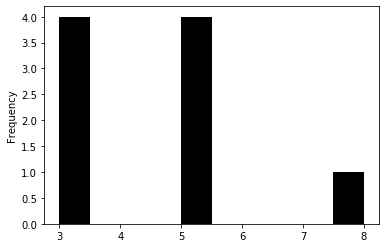

In [13]:
pandas.Series(w.cardinalities).plot.hist(color='k');

The `cardinalities` and `histogram` attributes help quickly spot asymmetries in
the number of neighbors. This, as we will see later in the book, is relevant
when using spatial weights in other analytical techniques (e.g.
spatial autocorrelation analysis or spatial regression). Here we see that there are four corner
observations with three neighbors, four edge observations with five neighbors,
and the one central observation has eight neighbors. There are also no
observations with four, six, or seven neighbors.

By convention, an ordered pair of contiguous observations constitutes a *join*
represented by a non-zero weight in a $W$. The attribute `s0` records the number
of joins.

In [14]:
w.s0

40.0

The `pct_nonzero` attribute provides a measure of the density (compliment of
sparsity) of the spatial weights matrix (if we had it stored explicitly, which
we don't):

In [15]:
w.pct_nonzero

49.382716049382715

which is equal to $100 \times (\texttt{w.s0} / \texttt{w.n}^2)$.

### Spatial Weights from real-world data

The regular lattice map encountered above helps us to understand the logic and
properties of PySAL's spatial weights class. However, the artificial nature of
that geography is of limited relevance to real world research problems.
Fortunately, PySAL supports the construction of spatial weights objects from a
number of commonly used spatial data formats. Here we demonstrate this
functionality for the case of census tracts in San Diego, California. Most spatial
data formats, such as shapefiles, are non-topological in that they encode the
polygons as a collection of vertices defining the edges of the geometry's
boundary. No information about the neighbor relations is explicitly encoded, so we
must construct it ourselves. Under the hood, PySAL uses efficient spatial indexing
structures to extract these.

In [16]:
san_diego_tracts = geopandas.read_file('../data/sandiego/sd_tracts_acs_clean.shp')
wq = weights.contiguity.Queen.from_dataframe(san_diego_tracts)

/home/serge/anaconda3/envs/gdsbook/lib/python3.6/site-packages/pysal/lib/weights/contiguity.py:185: UserWarning: There is one disconnected observation (no neighbors).
Island id: 103
  W.__init__(self, neighbors, ids=ids, **kw)


Note the warning about disconnected observations (no neighbors). The disconnected observation warning indicates that there are polygons in the shapefile that do not share any vertices with other polygons. Any time there is a disconnected observation, sometimes called a topological *island*, the graph is also disconnected into at least two one components. Further, graphs can have more than one disconnected component even without any islands. We will return to deal with this later in this chapter. For now we focus on the object just created.

Like before, we can visualize the adjacency relationships, but they are much more difficult to see without showing a closer detail:

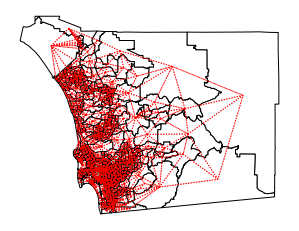

In [17]:
ax = san_diego_tracts.plot(edgecolor='k', facecolor='w')
wq.plot(san_diego_tracts, ax=ax, 
        edge_kws=dict(color='r', linestyle=':', linewidth=1),
        node_kws=dict(marker=''))
ax.set_axis_off()

So, showing more detail, we can get a glimpse of the complicated structure of the contiguity relationships between tracts in the center city:

[-13040000, -13020000, 3850000, 3860000]

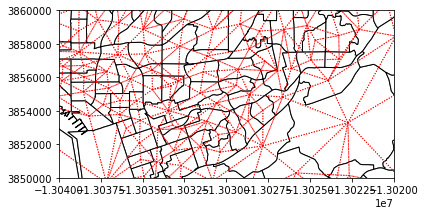

In [18]:
ax = san_diego_tracts.plot(edgecolor='k', facecolor='w')
f,ax = wq.plot(san_diego_tracts, ax=ax, 
        edge_kws=dict(color='r', linestyle=':', linewidth=1),
        node_kws=dict(marker=''))
ax.axis([-13040000,  -13020000, 3850000, 3860000])
#ax.set_axis_off()

The weights object for San Diego tracts have the same attributes and methods as
we encountered with our artificial layout above:

In [19]:
print(wq.n)
print(wq.pct_nonzero)

627
1.0067942074993195


First we have a larger number of spatial units. The spatial weights are
also much more sparse for the tracts than what we saw for our smaller toy
layout. Moreover, the cardinalities have a radically different distribution:

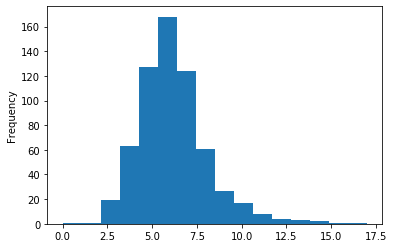

In [20]:
s = pandas.Series(wq.cardinalities)
s.plot.hist(bins=s.unique().shape[0]);

as the minimum number of neighbors is 0 (due to our disconnected observation), while there is one polygon with 17
queen neighbors. The most common number of neighbors is 6.

There is also a function to create the rook weights for the same dataframe:

0.8592599375777417


/home/serge/anaconda3/envs/gdsbook/lib/python3.6/site-packages/pysal/lib/weights/contiguity.py:34: UserWarning: There is one disconnected observation (no neighbors).
Island id: 103
  W.__init__(self, neighbors, ids=ids, **kw)


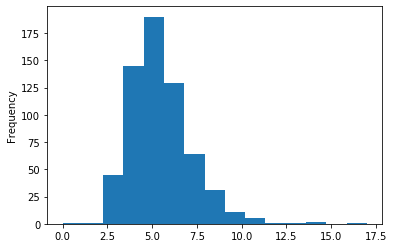

In [21]:
wr = weights.contiguity.Rook.from_dataframe(san_diego_tracts)
print(wr.pct_nonzero)
s = pandas.Series(wr.cardinalities)
s.plot.hist(bins=s.unique().shape[0]);

The cardinality histogram shifts downward due to the increasing sparsity of the
weights for the rook case relative to the queen criterion. Conceptually, this makes sense; all Rook neighbors are also Queen neighbors, since Queen includes neighbors that share an edge. But, not all Queen neighbors are Rook neighbors, since some Queen neighbors only share a point on their boundaries in common. 

The example above shows how the notion of contiguity, although more
straightforward in the case of a grid, can be naturally extended beyond the
particular case of a regular lattice. The principle to keep in mind is that we
consider contiguous (and hence call neighbours) observations which share part
of their border coordinates. In the queen case, a single point is enough to make
the join. For rook neighbours, we require a join to consist of one or more
shared edges. This distinction is probably less relevant in the real world that
in appears in the grid example above, and it is probably down to geocoding
issues rather than substantive differences. In any case, there are special cases
where this distinction can matter and it is useful to be familiar with the
differences between the two approaches and how to apply them.


We also see the same disconnected observation warning, so let's return to this
issue and explore it a bit further. PySAL indicates that the disconnected
observation has `id: 103`.

In [22]:
wr.islands

[103]

 Disconnected here means that this observation has no
neighbors according to the specific contiguity criterion. Checking the
`neighbors` attribute we see an empty list for this observation:

In [23]:
wr.neighbors[103]

[]

in contrast to say observation with `id: 10` which has six neighbors:

In [24]:
wr.neighbors[10]

[5, 214, 6, 9, 11, 12]

Disconnected observations, or islands, can cause problems for the spatial
analytics that rely on spatial weights. As such, there are different approaches
to deal with these observations so that they are no longer disconnected. One
approach relies on the notion of nearest neighbor weights, which we turn to
next.

## Distance Based Weights

In addition to contiguity, we can also define neighbor relations as a function of
the distance separating spatial observations. Usually, this means that a matrix expressing the distances between all pairs of observations are required. These are then provided to a **kernel** function which uses the proximity information to model proximity as a smooth function of distance. PySAL implements a family of
distance functions. Here we illustrate a selection beginning with the notion
of *nearest neighbor* weights.

### Knn weights

The first type of distance based weights defines the neighbor set of a
particular observation as containing its nearest $k$ observations, where the
user specifies the value of value $k$. To illustrate this for the San Diego
tracts we take $k=4$. This still leaves the issue of how to measure the distance
between these polygon objects, however. To do so we develop a representative
point for each of the polygons using the so called "center of mass" or centroid.

In [25]:
wk4 = weights.distance.KNN.from_dataframe(gdf, k=4)

The centroids are attributes of the polygon shapes that PySAL calculates from
the spatial information stored in the `GeoDataFrame`. Since we are dealing with
polygons in this case, PySAL uses inter-centroid distances to distance determine the
$k$ nearest observations to each polygon. 

The knn weights solve our island problem:

In [26]:
wk4.islands

[]

however, examination of the cardinality histogram for the knn weights shows us
that each observation has the same number of neighbors:

In [27]:
wk4.histogram

[(4, 9)]

This is by construction as the feature is at the very heart of the
KNN approach. In some cases, this is not an issue but a desired feature. In
other contexts, however, this characteristic of KNN weights can be undesirable.
In such situations, we can turn to other types of distance-based weights.

### Kernel weights

The knn rule assigns binary values to the weights for neighboring observations.
PySAL also supports continuously valued weights to reflect Tobler's first law
[1] in a more direct way: observations that are close to a unit have larger
valued weights than more distant observations.

Kernel weights are one of the most commonly-used kinds of distance weights. They
reflect the case where similarity/spatial proximity is assumed or expected to
decay with distance. The essence of kernel weights is that the weight between
observations $i$ and $j$ is based on their distance, but this is modulated by
a kernel function with certain properties. PySAL implements several kernels.
All of them share the properties of distance decay (thus encoding Tobler's First 
Law), but may decay at different rates with respect to distance.

As a computational note, it is worth mentioning that many of these distance-based deacy functions require more computation than the contiguity weights or K-nearest neighbor weights discussed above. This is because the contiguity & KNN structures embed simple assumptions about how shapes relate in space, while kernel functions relax several of those assumptions. Thus, they provide more flexibility at the expense of computation.

The simplest way to compute Kernel weights in PySAL involves a single function
call:

In [28]:
w_kernel = weights.distance.Kernel.from_dataframe(gdf)

Like KNN weights, the Kernel weights are based on distances between observations. By default, if the input data is an areal unit, we use a central representative point (like the centroid) for that polygon.
The value of the weights will be a function of two main options for
kernel weights: choice of kernel function; and the bandwidth. The
former controls how distance between $i$ and $j$ is "modulated" to produce a
the weight that goes in $w_{ij}$. In this respect, PySAL offers a large number
of functions that determine the shape of the distance
decay function. The bandwidth specifies the distance from each focal unit over which
the kernel function is applied. For observations separated by distances larger
than the bandwidth, the weights are set to zero.

The default values for kernels are to use a triangular kernel with a bandwidth distance
equal to the maximum knn=2 distance
for all observations. The latter implies a so-called fixed bandwidth were all
observations use the same distance for the cut-off. We can inspect this from
the generated `W` object:

In [29]:
w_kernel.function

'triangular'

for the kernel function, and:

In [30]:
w_kernel.bandwidth[0:5]

array([[1.0000001],
       [1.0000001],
       [1.0000001],
       [1.0000001],
       [1.0000001]])

For the bandwith applied to each observation.

Although simple, a fixed bandwith is not always the best choice. For example,
in cases where the density of the observations varies over the study region,
using the same threshold anywhere will result in regions with a high density
of neighbors while others with observations very sparsely connected. In these
situations, an *adaptive* bandwith -one which varies by observation and its
characteristics- can be preferred. Adaptive bandwidths are picked again using a K-nearest neighbor rule. A bandwidth for each observation is chosen such that, once the $k$-nearest observation is considered, all the remaining observations have zero weight.

For example, using the first ten tracts in our San Diego tract data, we can see that the centroids of each tract are not exactly regularly-spaced, although others do nearly fall into a regular spacing:

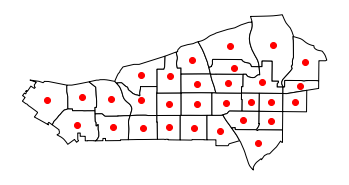

In [31]:
top_30 = san_diego_tracts.head(30)
ax = top_30.plot(facecolor='w', edgecolor='k')
ax = top_30.head(30).centroid.plot(color='r', ax=ax)
ax.set_axis_off()

We can see that the adaptive bandwidth adjusts for this:

In [32]:
w_adaptive = weights.distance.Kernel.from_dataframe(top_30, fixed=False, k=15)
w_adaptive.bandwidth

array([[7065.75104957],
       [5728.46240793],
       [5766.83702384],
       [4334.37049483],
       [4596.75793866],
       [3614.26794702],
       [3406.31834666],
       [3483.32856325],
       [3001.91264191],
       [2980.82767647],
       [2999.52550684],
       [3067.19959966],
       [2352.5156947 ],
       [2528.14492198],
       [2891.45948781],
       [2999.52550684],
       [2317.82469203],
       [2389.45906482],
       [2753.7624947 ],
       [3407.76610407],
       [3896.97847546],
       [4411.6620426 ],
       [2598.6627804 ],
       [2480.73728866],
       [2996.084241  ],
       [4123.83777069],
       [3965.08200809],
       [3001.91264191],
       [3112.19094718],
       [3659.29224551]])

And, we can visualize what these kernels look like on the map, too, by focusing on an individual unit and showing how the distance deacy attenuates the weight by grabbing the corresponding row of the full kernel matrix:

[None, None]

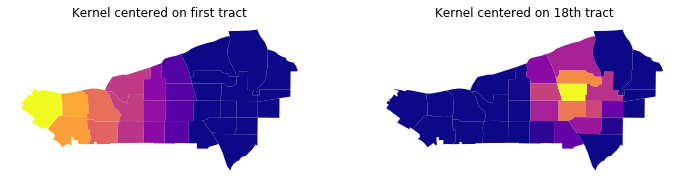

In [33]:
full_matrix, ids = w_adaptive.full() 
f,ax = plt.subplots(1,2,figsize=(12,6), subplot_kw=dict(aspect='equal'))
top_30.assign(weight_0 = full_matrix[0]).plot("weight_0", cmap='plasma', ax=ax[0])
top_30.assign(weight_15 = full_matrix[17]).plot("weight_15", cmap='plasma', ax=ax[1])
ax[0].set_title("Kernel centered on first tract")
ax[1].set_title("Kernel centered on 18th tract")
[ax_.set_axis_off() for ax_ in ax]

What the kernel looks like can be strongly affected by the structure of spatial proximity, so any part of the map can look quite different from any othe rpart of the map. By imposing a clear distance decay over several of the neighbors of each observation,
kernel weights incorporate Tobler's law very explicitly. Often, this comes at the cost of
increased memory requirements, as every single pair of observations within the
bandwidth distance is considered:

In [34]:
w_kernel.pct_nonzero

40.74074074074074

In many instances, this may be at odds with the nature of the spatial
interactions at hand, which operate over a more limited range of distance. In
these cases, expanding the neighborhood set beyond might lead us to consider
interactions which either do not take place, or are inconsequential. Thus, for
both substantive and computational reasons, it might make sense to further
limit the range, keeping impacts to be hyper-local.

## Distance bands and hybrid Weights

In some contexts, it makes sense to draw a circle around each observation and
consider as neighbors every other observation that falls within the circle.
In the GIS terminology, this is akin to drawing a buffer around each point and
performing a point-in-polygon operation that determines whether each of the
other observations are within the buffer. If they are, they are assigned a
weight of one in the spatial weights matrix, if not they receive a zero.

In [35]:
w_bdb = weights.distance.DistanceBand.from_dataframe(gdf, 1.5, binary=True)

This creates a binary distance weights where every other observation within
a distance of 1.5 is considered neighbor.

Hybrid weights, also available in PySAL, are matrices that
offer a blend of the threshold and continuous distance weights by truncating the
neighbor pairs to those separated by less than some distance threshold.

Let us for instance calculate a hybrid matrix that combines inverse distance
weights up to a certain threshold and then truncate the weights to zero for
everyone else. For this example we will return to the small lattice example
covered in the beginning:

In [36]:
w_hy = weights.distance.DistanceBand.from_dataframe(gdf, 1.5, binary=False)

We apply a threshold of 1.5 for this illustration. PySAL truncates continuous
weights at this distance. It is important to keep in mind that the threshold
distance must use the same units of distance as the units used to define the
matrix.

We can inspect the `weights` dictionary to see the weights, in this case, are
not 1 or 0 only, but there are values in-between:

In [37]:
w_hy.weights

{0: [1.0, 1.0, 0.7071067811865475],
 1: [1.0, 1.0, 0.7071067811865475, 1.0, 0.7071067811865475],
 2: [1.0, 0.7071067811865475, 1.0],
 3: [1.0, 0.7071067811865475, 1.0, 1.0, 0.7071067811865475],
 4: [0.7071067811865475,
  1.0,
  0.7071067811865475,
  1.0,
  1.0,
  0.7071067811865475,
  1.0,
  0.7071067811865475],
 5: [0.7071067811865475, 1.0, 1.0, 0.7071067811865475, 1.0],
 6: [1.0, 0.7071067811865475, 1.0],
 7: [0.7071067811865475, 1.0, 0.7071067811865475, 1.0, 1.0],
 8: [0.7071067811865475, 1.0, 1.0]}

which contrasts with the original weights:

In [38]:
w.weights

{0: [1.0, 1.0, 1.0],
 1: [1.0, 1.0, 1.0, 1.0, 1.0],
 2: [1.0, 1.0, 1.0],
 3: [1.0, 1.0, 1.0, 1.0, 1.0],
 4: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 5: [1.0, 1.0, 1.0, 1.0, 1.0],
 6: [1.0, 1.0, 1.0],
 7: [1.0, 1.0, 1.0, 1.0, 1.0],
 8: [1.0, 1.0, 1.0]}

### Great Circle distances

We must make one final curve before leaving the distance based weights. It is important that the
calculation of distances between objects takes the curvature of the Earth's
surface into account. This can be done before computing the spatial weights object, 
by transforming the coordinates of data points into a projected reference system, in 
a GIS, for example. If 
this is not possible or convenient, an approximation that considers the
curvature implicit in non-projected reference systems (e.g.
longitude/latitude) can be a sufficient workaround. PySAL provides such
approximation as part of its functionality.

To illustrate the relevance of ignoring this aspect altogether we will examine
distance based weights for the case of counties in the state of Texas. First, let us compute
a KNN-4 object that ignores the curvature of the Earth's surface:

In [39]:
texas = geopandas.read_file('../data/texas.shp')
knn4_bad = weights.distance.KNN.from_dataframe(texas, k=4) # ignore curvature of the earth

In [40]:
knn4_bad.histogram

[(4, 254)]

Next, let us take curvature into account. To do this, we require the
radious of the Earth expressed in a given metric. PySAL provides this number
in both miles and kilometres. For the sake of the example, we will use miles:

In [41]:
radius = geometry.sphere.RADIUS_EARTH_MILES
radius

3958.755865744055

With this measure at hand, we can pass it to the weights constructor (either
straight from a shapefile or from a `GeoDataFrame`) and distances will be
expressed in the units we have used for the radious, that is in miles in our
case:

In [42]:
knn4 = weights.distance.KNN.from_dataframe(texas, k=4, radius=radius)

In [43]:
knn4.histogram

[(4, 254)]

Comparing the resulting neighbor sets, we see that ignoring the curvature of the
Earth's surface can create erroneous neighbor pairs:

In [44]:
knn4[0]

{6: 1.0, 4: 1.0, 5: 1.0, 3: 1.0}

In [45]:
knn4_bad[0]

{6: 1.0, 4: 1.0, 5: 1.0, 13: 1.0}

## Set Operations on Weights

So far, we have seen different principles that guide how to build spatial
weights matrices. In this section, we explore how we can create new matrices
by *combining* different existing ones. This is useful in contexts where a
single neighborhood rule has flaws or when theory or other guiding principles
point in directions that require combining more than a single criterium.

We will explore these ideas in the section by returning to the problem we
faced above of an island observation encountered
when constructing the weights for the San Diego tracts. A number of ways exist 
to solve this island problem through a combination of the original contiguity
weights and the nearest neighbor weights. We will examine two different
approaches that provide the same solution, thus illustrating the value of set
operations in PySAL.

### Editing/connecting disconnected observations

The first approach we adopt is to find the nearest neighbor for the island observation
and then add this pair of neighbors to extend the neighbor pairs from the
original contiguity weight to obtain a fully connected set of weights. Recall that our tract shapefile in San Diego had a disconnected observation, number 103. For us to reattach this tract, we can assign it to be "connected" to its nearest neighbor. 

But, since this is real data, we might want to take a look first by plotting our disconnected tract in red on top of the existing tracts. To do this, let's first extract our "problem" geometry:

In [46]:
disconnected_tract = san_diego_tracts.iloc[[103]]

build a good "viewing" window around this polygon by *buffering* it, giving a good context around the focal unit of observation:

In [47]:
buffer = disconnected_tract.geometry.buffer(2000)
west, south, east, north = buffer.bounds.values[0]

Then, we can make a plot of the tracts, zooming into the frame established by our buffer:

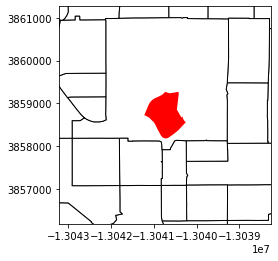

In [48]:
ax = san_diego_tracts.plot(facecolor='w', edgecolor='k')
ax = disconnected_tract.plot(ax=ax, color='red')
ax.axis([west, east, south, north])
plt.show()

From this, we can see *why* our tract is disconnected, rather than simply *that* it is disconnected. The larger square tract *contains* the tract above, our island. Conceptually, they sit on top of one another rather than touching one another. Since they do not share any vertices on their boundaries in common (since the polygon below entirely contains the polygon above), they do not actually *touch* using our definition of contiguity. 

That aside, we can still re-attach the observation to the graph by connecting it to its nearest neighbor. To do this, we can construct the KNN graph as we did above, but set `k=1`, so observations are only assigned to their nearest neighbor:

In [49]:
wk1 = weights.distance.KNN.from_dataframe(san_diego_tracts, k=1)

/home/serge/anaconda3/envs/gdsbook/lib/python3.6/site-packages/pysal/lib/weights/weights.py:170: UserWarning: The weights matrix is not fully connected. There are 154 components
  warnings.warn("The weights matrix is not fully connected. There are %d components" % self.n_components)


In this graph, all our observations are connected to *at least* one other observation, so island observation is connected to:

In [50]:
wk1.neighbors[103]

[104]

To attach our island, we need to create a copy of the `neighbors` dictionary and update the entry for `103`, giving it `104` as a neighbor. So, first we copy the neighbors:

In [51]:
neighbors = wr.neighbors.copy()

and then we are change the entry for the island observation to include its
nearest neighbor (`104`) as well as update `104` to have `103` as a neighbor:

In [52]:
neighbors[103].append(104)
neighbors[104].append(103)
w_fixed = weights.W(neighbors)
print(w_fixed.islands)
print(w_fixed.histogram)

[]
[(1, 1), (2, 1), (3, 45), (4, 145), (5, 190), (6, 129), (7, 64), (8, 25), (9, 6), (10, 11), (11, 5), (12, 1), (13, 1), (14, 1), (15, 1), (16, 0), (17, 1)]


now, when we visualize the graph in the area around our island:

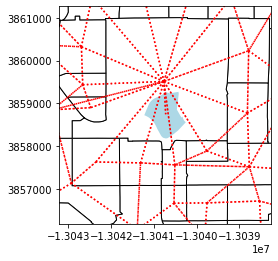

In [53]:
f,ax = w_fixed.plot(san_diego_tracts, edge_kws=dict(color='red', linestyle=':'))
ax = san_diego_tracts.plot(facecolor='w', edgecolor='k', ax = ax)
ax = disconnected_tract.plot(ax=ax, color='lightblue')
ax.axis([west, east, south, north])
plt.show()

We can see that our island is now connected to its nearest neighbor, which happens to *also* be the observation which contains it. 

### Using the `union` of matrices

A more elegant approach to the island problem makes use of PySAL's support for
*set theoretic operations* on PySAL weights:

In [54]:
w_fixed_sets = weights.set_operations.w_union(wr, wk1)
w_fixed_sets.histogram

[(1, 1),
 (2, 1),
 (3, 45),
 (4, 145),
 (5, 188),
 (6, 131),
 (7, 64),
 (8, 25),
 (9, 6),
 (10, 11),
 (11, 5),
 (12, 1),
 (13, 1),
 (14, 1),
 (15, 1),
 (16, 0),
 (17, 1)]

It is important to mention that this approach is not exactly the same, at least
in principle, as the one above. It could be that the nearest
observation was not originally a neighbor and, in this case, the resulting
matrices would differ. This is a rare but theoretically possible situation.

### Block Weights

A final type of spatial weight we examine here are block weights. Membership in
a group or set defines the neighbor relationships. Block weights connect every
observation in a data set that belongs to the same category in a list provided
*ex-ante*. Usually, this list will have some relation to geography 
of the observations but, technically speaking, all one needs to create block
weights is a list of memberships. In essence, a hierarchical structure groups
individual observations and assigns a value of one to the weight for all
pair-members of the group, and a value of zero to pairs involving observations
belonging to different groups.


To demonstrate this class of spatial weights, we will use the tract dataset for
San Diego and focus on their county membership:

In [55]:
san_diego_tracts[['GEOID', 'state', 'county', 'tract']].head()

,GEOID,state,county,tract
0,06073000100,06,073,000100
1,06073000201,06,073,000201
2,06073000202,06,073,000202
3,06073000300,06,073,000300
4,06073000400,06,073,000400


Every tract has a unique ID (`GEOID`) and a county ID, shared by all tracts in
the same county. Since the entire region of San Diego is in California, the
state ID is the same across the dataset.

To build a block weights matrix, we do not even need spatial data beyond the
list of memberships. In this case, we will use the county membership:

In [56]:
# NOTE: since this is a large dataset, it might take a while to process
w_bl = weights.util.block_weights(san_diego_tracts['county'].values, 
                                  ids=san_diego_tracts['GEOID'].values)

As a check, let's consider the first two rows in the table above. If the block
weights command has worked out correctly, both should be neighbors:

In [57]:
'06073000201' in w_bl['06073000100']

True

We can use block weights as an intermediate step in more involved analyses
of spatial linkages. Suppose for example, the researcher wanted to allow for
queen neighbors within counties but not for tracts across different counties.
Tracts from different counties are not considered neighbors. To create such
as spatial weights matrix would require a combination of the queen and the block
criteria, and PySAL can implement that blending through one of the set operations.


### Visualizing weight set operations

We finish the chapter by illustrating the concepts above using 
the 32 states of Mexico. We compare the neighbor graphs that results
from the different criteria used to define neighbor relations. The graphs are
constructed by specifying the nodes at the polygon centroids for each of the
states. Edges are then drawn between a pair of nodes to reflect a neighbor
relation between the states according to the specific definition.

We first read in the data for Mexico:

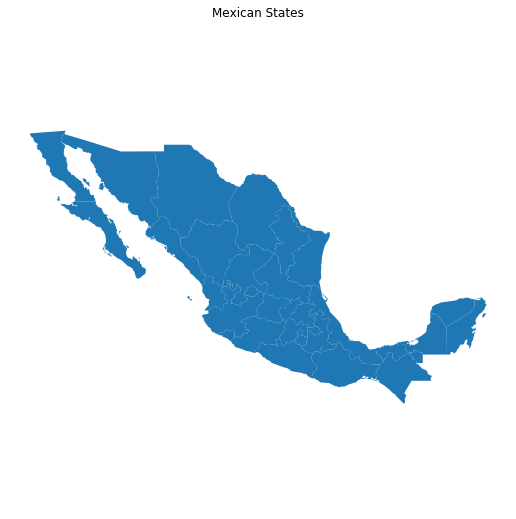

In [58]:
mx = geopandas.read_file('../data/mexicojoin.shp')
f, ax = plt.subplots(1, figsize=(9, 9))
mx.plot(ax=ax)
ax.set_axis_off()
ax.set_title('Mexican States')
plt.axis('equal')
plt.show()


We will contrast the connectivity structure for the three following types of spatial weights:

- Queen contiguity weights
- Block weights
- Combination of Block+Queen weights


Beginning with Queen weights:

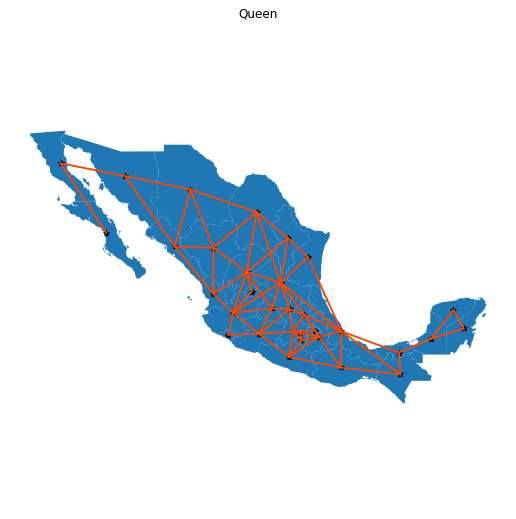

In [59]:
queen_mx = weights.contiguity.Queen.from_dataframe(mx)
f, ax = plt.subplots(1, figsize=(9, 9))
mx.plot(ax=ax)
queen_mx.plot(mx,edge_kws=dict(linewidth=1.5, color='orangered'), node_kws=dict(marker='*'),  ax=ax, )
ax.set_axis_off()
ax.set_title('Queen')
plt.axis('equal')
plt.show()

For the block weights, we use the official designation of regions from the federal government:

/home/serge/anaconda3/envs/gdsbook/lib/python3.6/site-packages/pysal/lib/weights/weights.py:170: UserWarning: The weights matrix is not fully connected. There are 5 components
  warnings.warn("The weights matrix is not fully connected. There are %d components" % self.n_components)


Text(0.5, 1, 'Mexican Regions')

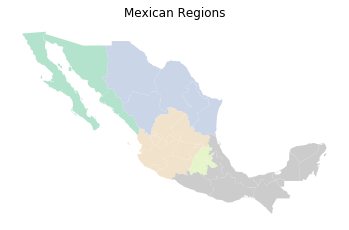

In [60]:
ax = mx.plot(column='INEGI2', categorical=True, cmap='Pastel2')
block_mx = weights.util.block_weights(mx['INEGI2'].values)
ax.set_axis_off()
ax.set_title("Mexican Regions")

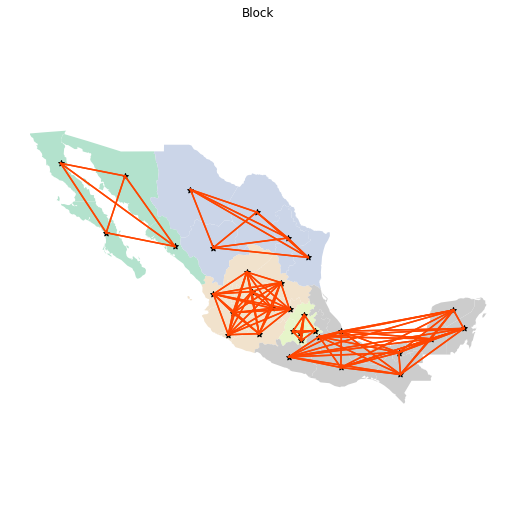

In [61]:
f, ax = plt.subplots(1, figsize=(9, 9))
mx.plot(column='INEGI2', categorical=True, 
        cmap='Pastel2', ax=ax)
block_mx.plot(mx, edge_kws=dict(linewidth=1.5, 
                                color='orangered'), 
                  node_kws=dict(marker='*'), ax=ax)
ax.set_axis_off()
ax.set_title('Block')
plt.axis('equal')
plt.show()

Next, we construct the union of queen contiguity and block weights

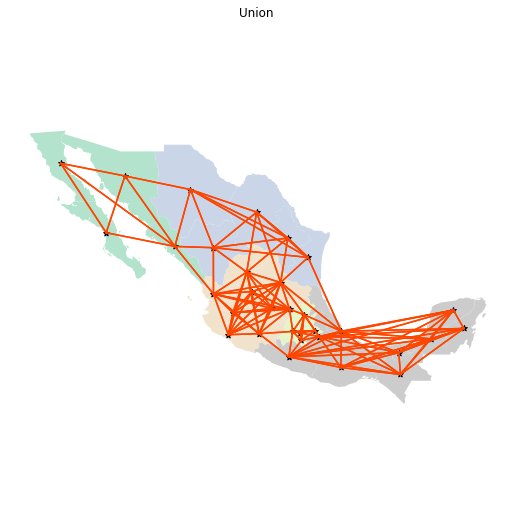

In [62]:
union_mx = weights.set_operations.w_union(block_mx, queen_mx)

f, ax = plt.subplots(1, figsize=(9, 9))
mx.plot(column='INEGI2', categorical=True, cmap='Pastel2', ax=ax)
union_mx.plot(mx, edge_kws=dict(linewidth=1.5, 
                                color='orangered'), 
              node_kws=dict(marker='*'), ax=ax)
ax.set_axis_off()
ax.set_title('Union ')
plt.axis('equal')
plt.show()

Finally, we compare the three neighbor graphs side by side:

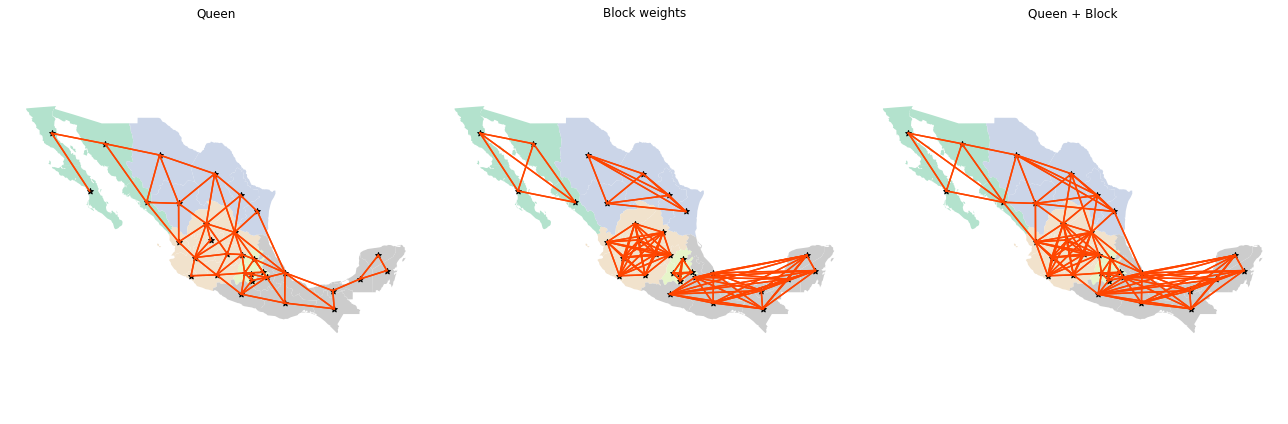

In [63]:
f, axs = plt.subplots(1, 3, figsize=(18, 6))


# Contiguity
ax = axs[0]
mx.plot(column='INEGI2', categorical=True, 
        cmap='Pastel2', ax=ax)
queen_mx.plot(mx, edge_kws=dict(linewidth=1.5, color='orangered'), 
              node_kws=dict(marker='*'), ax=ax)
ax.set_axis_off()
ax.set_title('Queen')
ax.axis('equal')

# Block
ax = axs[1]
mx.plot(column='INEGI2', categorical=True, 
        cmap='Pastel2', ax=ax)
block_mx.plot(mx, edge_kws=dict(linewidth=1.5, color='orangered'), 
              node_kws=dict(marker='*'), ax=ax)
ax.set_axis_off()
ax.set_title('Block weights')
ax.axis('equal')

# Union
ax = axs[2]
mx.plot(column='INEGI2', categorical=True, 
        cmap='Pastel2', ax=ax)
union_mx.plot(mx, edge_kws=dict(linewidth=1.5, color='orangered'), 
              node_kws=dict(marker='*'), ax=ax)
ax.set_axis_off()
ax.set_title('Queen + Block')
plt.axis('equal')
f.tight_layout()
plt.show()

Focusing on the Queen and Block graphs, there are clear distinctions between the
connectivity structures. The Block graph is visually more dense in particular areas relative to the
Queen graph and this is borne out in their sparsity measures:

In [64]:
block_mx.pct_nonzero

19.140625

In [65]:
queen_mx.pct_nonzero

13.4765625

The other distinguishing characteristic can be seen in the number of connected
components in the different graphs. The Queen graph has a single connected
component - which in graph theory terms, means for all pairs of states there is
at least one path of edges that connects the two states. The Block graph has
five connected components, one for each of the five regions. Moreover, each of
these connected components is fully-connected, meaning there is an edge that
directly connects each pair of member states. However, there are no edges
between states belonging to different blocks (or components).


As we will see in later chapters, certain spatial analytical techniques require
a fully connected weights graph. In these cases, we could adopt the Queen
definition since this satisfies the single connected component requirement.
However, we may wish to use the Union weights graph as that provides a single
connected component, but offers a blend of different types of connectivity
intensities, with the intra-regional (block) linkages being very dense, while
the inter-regional linkages are thinner but provide for the single connected
component.

## Use case: Boundary detection

Spatial weights are ubiquitous in the analysis of spatial patterns in data, since they provide a direct method to represent spatial structure. 
However, spatial weights are sometimes useful in their own right, such as when examining latent structures directly in the graphs themselves or when using them to conduct descriptive analysis. 
One clear use case that arises in the analysis of social data is to characterize latent *data discontinuities*. By *data discontinuity*, we mean a single border (or collection of borders) where data for a variate (or many variates) of interest change rapidly. 
These can be used in stochastic models of boundaries [2-4] or used to adapt classic empirical outlier detection methods. 
Below, we'll show one model-free way to identify empirical boundaries in your data. 

First, let's consider the median household income for our census tracts in San Diego:

In [66]:
from booktools import choropleth

Text(0.5, 1, 'Median Household Income')

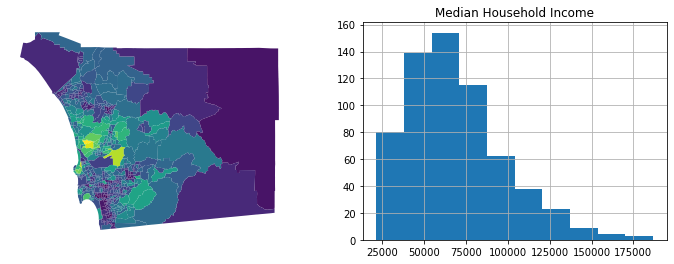

In [67]:
f,ax = plt.subplots(1,2, figsize=(12,4))
san_diego_tracts.plot('Median HH', ax=ax[0])
ax[0].set_aspect('equal')
ax[0].set_axis_off()
san_diego_tracts['Median HH'].hist(ax=ax[1])
ax[1].set_title("Median Household Income")

Now, we see some cases where there are very stark differences between neighboring areas, and some cases where there are essentially no difference between adjacent areas. Digging into this, we can examine the *distribution of differences* in neighboring areas using the adjacency list:

In [68]:
adjlist = wr.to_adjlist() 
adjlist.head()

,focal,neighbor,weight
0,0,112,1.0
1,0,1,1.0
2,0,2,1.0
3,0,203,1.0
4,1,0,1.0


This provides us with a table with three columns. `Focal` is the column containing the "origin" of the link, `neighbor` is the column containing the "destination" of the link, and `weight` contains how strong the link from `focal` to `neighbor` is. Since our weights are *symmetrical*, this table contains two entries per pair of neighbors, one for `(focal,neighbor)` and the other for `(neighbor,focal)`. Using this table and `pandas`, we can merge up the focal units' & neighboring units' median household incomes:

In [69]:
adjlist_wealth = adjlist.merge(san_diego_tracts[['Median HH']], how='left', 
                               left_on='focal', right_index=True)\
                        .merge(san_diego_tracts[['Median HH']], how='left',
                               left_on='neighbor', right_index=True, 
                               suffixes=('_focal', '_neighbor'))
adjlist_wealth.head()

,focal,neighbor,weight,Median HH_focal,Median HH_neighbor
0,0,112,1.0,125370.0,36686.0
1,0,1,1.0,125370.0,100436.0
2,0,2,1.0,125370.0,60929.0
3,0,203,1.0,125370.0,57642.0
4,1,0,1.0,100436.0,125370.0


Now, we have the wealth at both the focal observation and the neighbor observation. The difference between these two columns provides us every pairwise difference between *adjacent* tracts:

In [70]:
adjlist_wealth['diff'] = adjlist_wealth['Median HH_focal'] - adjlist_wealth['Median HH_neighbor']

With this difference information we can do a few things. First, we can compare whether or not this *distribution* is distinct from the distribution of non-neighboring tracts' differences in wealth. 

To do this, we can first compute the all-pairs differences in wealth using the `numpy.subtract` function. Some functions in numpy have special functionality; these `ufuncs` (short for "universal functions") often support special applications to your data. Here, we will use `numpy.subtract.outer` to take the difference over the "outer cartesian product" of two vectors; in practice, this results in the subtraction of all of the combinations of the input vectors:

In [71]:
all_pairs = numpy.subtract.outer(san_diego_tracts['Median HH'], san_diego_tracts['Median HH'])

/home/serge/anaconda3/envs/gdsbook/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: outer method for ufunc <ufunc 'subtract'> is not implemented on pandas objects. Returning an ndarray, but in the future this will raise a 'NotImplementedError'. Consider explicitly converting the Series to an array with '.array' first.
  """Entry point for launching an IPython kernel.


Then, we need to filter out those cells of `all_pairs` that are neighbors. Fortunately, our weights matrix is *binary*. So, subtracting it from an $N \times N$ matrix of $1$s will result in the *complement* of our original weights matrix:

In [72]:
complement_wr = 1 - wr.sparse.toarray()

Using this compelement, we can filter the `all_pairs` matrix to only consider the differences in median household income for tracts that are not neighboring: 

In [73]:
non_neighboring_diffs = (complement_wr * all_pairs).flatten()

Now, we can compare the two distributions of the difference in wealth:

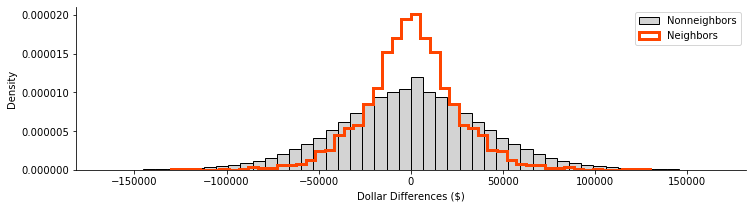

In [74]:
f = plt.figure(figsize=(12,3))
plt.hist(non_neighboring_diffs, color='lightgrey', 
         edgecolor='k', density=True, bins=50, label='Nonneighbors')
plt.hist(adjlist_wealth['diff'], 
         color='salmon', edgecolor='orangered', 
         linewidth=3, density=True, 
         histtype='step', bins=50, label='Neighbors')
seaborn.despine()
plt.ylabel("Density")
plt.xlabel("Dollar Differences ($)")
plt.legend()

From this, we can see that the two distributions are distinct, with the distribution of difference in *non-neighboring* tracts being slightly more dispersed than that for *neighboring* tracts. Thus, on the whole, this means that neighboring tracts have more *smaller differences in wealth* than nonneighboring tracts. This is consistent with the behavior we will talk about in later chapters concerning *spatial autocorrelation*, the tendency for observations to be statistically more similar to nearby observations than they are to distant observations. 

With this, we can then find our *most extreme* observed differences in wealth. Since our links are symmetric, the table sort is symmetric. So, we can focus only on focal observations with *the most extreme* difference in wealth from their immediate neighbors, focusing only on those where the *focal* is higher. 

In [75]:
extremes = adjlist_wealth.sort_values('diff', ascending=False).head(10)
extremes

,focal,neighbor,weight,Median HH_focal,Median HH_neighbor,diff
770,148,142,1.0,171094.0,41250.0,129844.0
767,148,180,1.0,171094.0,49050.0,122044.0
1144,219,217,1.0,168167.0,53173.0,114994.0
768,148,181,1.0,171094.0,69896.0,101198.0
2359,439,442,1.0,160694.0,70492.0,90202.0
0,0,112,1.0,125370.0,36686.0,88684.0
1139,219,423,1.0,168167.0,80038.0,88129.0
1147,219,412,1.0,168167.0,83295.0,84872.0
1145,219,443,1.0,168167.0,83316.0,84851.0
105,20,42,1.0,121518.0,37788.0,83730.0


Thus, we see that observation $148$ appears often on the the `focal` side, suggesting it's quite distinct from its nearby polygons. We also see observation $219$ often in the `focal` column. 

To verify whether these differences are truly beyond the pale, we can use a map randomization strategy. In this case, we shuffle the map and compute *new* `diff` columns. But, this time, `diff` represents the difference between random neighbors, rather than the neighbor structure we did observe, encoded in our Rook contiguity matrix. Using many `diff` vectors, we can find the observed differences which tend to be much larger than those encountered in randomly-drawn maps of household income.

So, to start, we can construct many random `diff` vectors:

In [76]:
n_simulations = 1000
simulated_diffs = numpy.empty((len(adjlist), n_simulations))
for i in range(n_simulations):
    median_hh_focal = adjlist_wealth['Median HH_focal'].values
    random_wealth = san_diego_tracts[['Median HH']].sample(frac=1, replace=False).reset_index()
    adjlist_random_wealth = adjlist.merge(random_wealth, left_on='focal', right_index=True)\
                                   .merge(random_wealth, left_on='neighbor', right_index=True, 
                                          suffixes=('_focal','_neighbor'))
    simulated_diffs[:,i] = adjlist_random_wealth['Median HH_focal'] - adjlist_random_wealth['Median HH_neighbor']

After running our simulations, we get many distributions of pairwise differences in household income. Below, we can see the shroud of all of the simulated differences, shown in black, and our observed differences, shown in red:

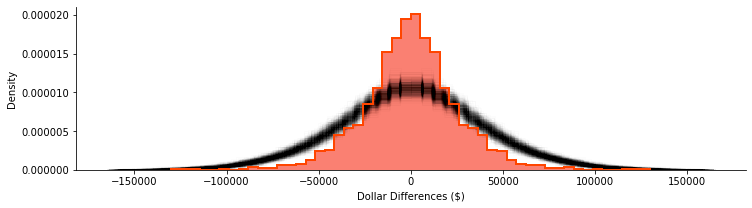

In [77]:
f = plt.figure(figsize=(12,3))
plt.hist(adjlist_wealth['diff'], 
         color='salmon', bins=50, density=True,
         alpha=1, linewidth=4)
[plt.hist(simulation, histtype='step', 
         color='k', alpha=.01, linewidth=1, 
         bins=50, density=True) for simulation in simulated_diffs.T]
plt.hist(adjlist_wealth['diff'], histtype='step', 
         edgecolor='orangered', bins=50, density=True,
         linewidth=2)
seaborn.despine()
plt.ylabel("Density")
plt.xlabel("Dollar Differences ($)")
plt.show()

Again, our random distribution is much more dispersed than our observed distribution of the differences between nearby tracts. Empirically, we can pool our simulations and construct and use their quantiles to summarize how unlikely any of our *observed* differences are if neighbors' household incomes were randomly assigned:

In [78]:
pooled_diffs = simulated_diffs.flatten()
lower, median, upper = numpy.percentile(pooled_diffs, q=(.5,50,99.5))
outside = (adjlist_wealth['diff'] < lower) | (adjlist_wealth['diff'] > upper)

So, despite the fact that that our observed differences are less dispersed on average, we can identify three boundaries in the data that are in the top 1% most extreme differences in neighboring household incomes across the map. These boundaries are shown in the table below:

In [79]:
adjlist_wealth[outside]

,focal,neighbor,weight,Median HH_focal,Median HH_neighbor,diff
736,142,148,1.0,41250.0,171094.0,-129844.0
767,148,180,1.0,171094.0,49050.0,122044.0
770,148,142,1.0,171094.0,41250.0,129844.0
933,180,148,1.0,49050.0,171094.0,-122044.0
1131,217,219,1.0,53173.0,168167.0,-114994.0
1144,219,217,1.0,168167.0,53173.0,114994.0


Note that one of these, observation $148$, appears in both boundaries. This means that the observation is likely to be *outlying*, extremely unlike *all* of its neighbors. These kinds of generalized neighborhood comparisons are discussed in the subsequent chapter on Local Spatial autocorrelation.

It is most helpful, though, to visualize this on a map, focusing on the first two boundaries around observation $148$, and then the second boundary between observation $217$ and $219$, shown in the larger context of San Diego incomes:

[-13068503.404883943,
 -13006196.85363941,
 3857713.0707310555,
 3903955.682213868]

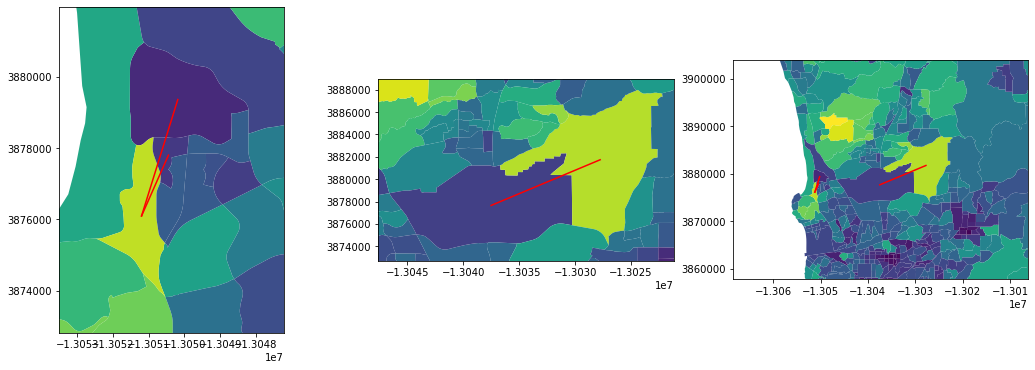

In [80]:
f,ax = plt.subplots(1,3,figsize=(18,6), 
                    subplot_kw=dict(aspect='equal'))
for i in range(3):
    san_diego_tracts.plot('Median HH', ax=ax[i])
first_focus = san_diego_tracts.iloc[[148,142]]
ax[0].plot(first_focus.centroid.x, first_focus.centroid.y, color='red')
ax[2].plot(first_focus.centroid.x, first_focus.centroid.y, color='red')
west,east,south,north = first_focus.buffer(1000).total_bounds
ax[0].axis([west, south, east, north])

second_focus = san_diego_tracts.iloc[[148,180]]
ax[0].plot(second_focus.centroid.x, second_focus.centroid.y, color='red')
ax[2].plot(second_focus.centroid.x, second_focus.centroid.y, color='red')

third_focus = san_diego_tracts.iloc[[217, 219]]
ax[1].plot(third_focus.centroid.x, third_focus.centroid.y, color='red')
ax[2].plot(third_focus.centroid.x, third_focus.centroid.y, color='red')
west,east,south,north = third_focus.buffer(1000).total_bounds
ax[1].axis([west, south, east, north])

area_of_focus = pandas.concat((first_focus, second_focus, third_focus)).buffer(16000).total_bounds
west, east, south, north = area_of_focus
ax[2].axis([west, south, east, north])

These are the starkest contrasts in the map, and result in the most distinctive divisions between adjacent tracts' household incomes. 

## Questions

1. Rook contiguity & Queen contiguity are two of three kinds of contiguity that are defined in terms of chess analogies. The third kind, *Bishop contiguity*, applies when two observations are considered connected when they share single vertices, but are considered *disconnected* if they share an edge. This means that observations that exhibit Queen contiguity are those that exhibit either Rook or Bishop contiguity. Using the Rook and Queen contiguity matrices we built for San Diego and the `Wsets.w_difference` function, are there any Bishop-contiguous observations in San Diego? 

2. Different kinds of spatial weights objects can result in very different kinds of graph structures. Considering the `cardinalities` of the Queen, Block, and union of Queen & Block, which graph type has the highest average cardinality? Why might this be the case? Which graph has more nonzero entries?

3. Comparing their average cardinality and percentage of nonzero links, which graph in this chapter has the *most sparse* structure? That is, which graph is the most sparsely connected?

4. In this chapter, we worked with regular *square* lattices using the `lat2W` function. In the same manner, the `hexLat2W` function can generate *hexagonal regular lattices*. For lattices of size (3,3), (6,6), and (9,9) for Rook & Queen `lat2W`, as well as for `hexLat2W`:

    1. examine the average cardinality. Does `lat2W` or `hexLat2W` have higher average cardinality? 
    2. Further, make a histogram of the cardinalities. Which type of lattice has higher variation in its number of neighbors? 
    3. Why is there no `rook=True` option in `hexLat2W`, as there is in `lat2W`?

5. The *Voronoi diagram* is a common method to construct polygons from a point dataset. A Voronoi diagram is built up from *Voronoi cells*, each of which contains the area that is closer to its source point than any other source point in the diagram. Further, the Queen contiguity graph for a *Voronoi diagram* obeys a number of useful properties, since it is the *Delaunay Triangulation* of a set of points. 
    1. Using the following code, build and plot the voronoi diagram for the *centroids* of Mexican states, with the states and their centroids overlayed:
    ```python
    from pysal.lib.weights.distance import get_points_array
    from pysal.lib.cg import voronoi_frames
    
    centroid_coordinates = get_points_array(mx.centroid)
    cells, centers = voronoi_frames(centroid_coordinates)
    
    ax = cells.plot(facecolor='none', edgecolor='k')
    mx.plot(ax=ax, edgecolor='red', facecolor='whitesmoke', alpha=.5)
    mx.centroid.plot(ax=ax,color='red', alpha=.5, markersize=10)
    ax.axis(mx.total_bounds[[0,2,1,3]])
    plt.show()
    ```
    2. Using the `weights.Voronoi` function, build the Voronoi weights for the Mexico states data.
    3. Compare the connections in the Voronoi and Queen weights for the Mexico states data. Which form is more connected? 
    4. Make a plot of the Queen contiguity and Voronoi contiguity graphs to compare them visually, like we did with the block weights & Queen weights. How do the two graphs compare in terms of the length of their links and how they connect the Mexican states?
    5. Using `weights.set_operations`, find any links that are in the Voronoi contiguity graph, but not in the Queen contiguity graph. Alternatively, find any links that are in the Queen contiguity graph, but not the Voronoi contiguity graph. 

6. Interoperability is important for the Python scientific stack. Thanks to standardization around the `numpy` array and the `scipy.sparse` array datastructures, it is simple and computationally-easy to convert objects from one representation to another:
    1. Using `w.to_networkx()`, convert the Mexico Regions Queen+Block weights matrix to a `networkx` graph. Compute the Eigenvector Centrality of that new object using `networkx.eigenvector_centrality`
    2. Using `w.sparse`, compute the number of connected components in the Mexico Regions Block weights matrix using the `connected_components` function in `scipy.sparse.csgraph`. 
    3. Using `w.sparse`, compute the all-pairs shortest path matrix in the Mexico Queen weights matrix using the `shortest_path` function in `scipy.sparse.csgraph`. 
    
7. While every node in a $k$-nearest neighbor graph has 5 neighbors, there is a conceptual difference between *indegree* and *outdegree* of nodes in a graph. The *outdegree* of a node is the number of outgoing links from a node; for a K-Nearest Neighbor graph, this is $k$ for every variable. The *indegree* of a node in a graph is the number of *incoming* links to that node; for a K-Nearest Neighbor graph, this is the number of other observations that pick the target as their nearest neighbor. The *indegree* of a node in the K-Nearest Neighbor graph can provide a measure of *hubbiness*, or how central a node is to other nodes. 
    1. Using the San Diego Tracts data, build a $k=6$ nearest neighbor weight and call it `knn_6`. 
    2. Verify that the $k=6$ by taking the row sum over the weights matrix in `knn_6.sparse`.
    3. Compute the indegree of each observation by taking the *column sum* over the weights matrix in `knn_6.sparse`, and divide by 6, the outdegree for all observations. 
    4. Make a histogram of the indegrees for the $k=6$ weights. How evenly-distributed is the distribution of indegrees?
    5. Make a new histogram of the indegree standardized by the outdegree when $k=26$. Does hubbiness reduce when increasing the number of $k$-nearest neighbors?

8. Sometimes, graphs are not simple to construct. For the `san_diego_neighborhoods` dataset:
    1. Build the Queen contiguity weights, and plot the graph on top of the neighborhoods themselves. How many connected components does this Queen contiguity graph have? 
    2. Build the K-Nearest Neighbor graph for the default, $k=2$. How many connected components does this K-Nearest Neighbor graph have? 
    3. What is the smallest $k$ that you can find for the K-Nearest Neighbor graph to be fully-connected?
    4. In graph theory, a link whose *removal* will increase the number of connected components in a graph is called a *bridge*. In the fully-connected KNN graph with the smallest $k$, how many bridges are there between the north and south components? *(hint: use the plotting functionality)*
    5. What are the next two values of $k$ required for there to be an *additional* bridge at that $k$?

## References

[1] Tobler, W. R. "A computer movie simulating urban growth in the Detroit region." *Economic Geography* 46, no. sup1 (1970): 234-240.

[2] Lu, H, and Carlin, B. 2005. “Bayesian Areal Wombling for Geographical Boundary Analysis.” *Geographical Analysis* 37 (3): 265–285.

[3] Fitzpatrick, M C.,Preisser, E.L., Porter, A., Elkinton, J., Waller, L.A., Carlin, B. P., and Ellison, A.M. 2010. “Ecological Boundary Detection Using Bayesian Areal Wombling.” *Ecology* 91 (12): 3448–3455.

[4] Dean, N., Dong, G., and Price, G. "Frontiers in Residential Segregation: Understanding Neighbourhood Boundaries and their Impacts." *Tijdschrift voor economische en sociale geografie*, in press

## Further Reading

LeSage, James P., and R. Kelley Pace. 2014. “The Biggest Myth in Spatial Econometrics.” *Econometrics* 2(4): 217–49. https://doi.org/10.3390/econometrics2040217.

Griffith, D. A. 1996. “Some Guidelines for Specifying the Geographic Weights Matrix Contained in Spatial Statistical Models.” In *Practical Handbook of Spatial Statistics*, edited by Sandra Lach Arlinghaus, 65–82. Boca Raton, FL: CRC Press.


---

<a rel="license" href="http://creativecommons.org/licenses/by-nc-nd/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-nc-nd/4.0/88x31.png" /></a><br />This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-nc-nd/4.0/">Creative Commons Attribution-NonCommercial-NoDerivatives 4.0 International License</a>.
---
jupyter:
  jupytext:
    formats: ipynb,md
    text_representation:
      extension: .md
      format_name: markdown
      format_version: '1.1'
      jupytext_version: 1.1.6
  kernelspec:
    display_name: Python 3
    language: python
    name: python3
---

# Spatial Weights

## Introduction

Spatial weights are widely used in geographic data science to represent geographical relationships between the observational units in a spatially referenced dataset. By expressing the notion of geographical proximity or connectedness, spatial weights are the main mechansim through which the spatial information in geographical data is brought to bear in the subsequent analysis.

For example, proximity and adjacency are common spatial questions:

    What neighborhoods surround yours?
    How many gas stations are within 5 miles of my stalled car? 

As stated above, these are spatial questions that target specific information about the spatial relationships between a specific target ("your neighborhood," "my stalled car") and surrounding relevant sites ("nearby gas stations," "adjacent neighborhoods"). However, for us to use this information in statistical analysis, it's often necessary to have computed these relationships between all pairs of observations. This means that, for geographic data science, we are building a *topology*---a mathematical structure that expresses the geometric and spatial relationships between observations---that we can use to examine the data. Spatial weights provide this topology, letting us embed all of our observations in space together, rather than asking and answering single questions about your nearby neighborhoods. 

Since they provide a way to represent these spatial relationships, spatial weights are widely utilized throughout spatial and geographic data science.
In what follows, we first consider different approaches to construct spatial weights, distinguishing between those based on contiguity/adjacency relations from weights obtained from distance based relationships. We then discuss the case of hybrid weights which combine one or more spatial operations in deriving the neighbor relationships between observations. We illustrate all of these concepts through the spatial weights class in PySAL which provides a rich set of methods and characteristics for spatial weights. We also demonstrate its functionality regarding set theory, which permits the derivation of weights through application of notions from set theory. Throughout the chapter, we discuss common file formats used to store spatial weights of different types, and we include visual discussion of spatial weights, making these sometimes abstract constructs more intuitive.

In [81]:
%matplotlib inline

from pysal.lib import weights
from pysal.lib import cg as geometry
import geopandas
import seaborn
import pandas 
import numpy
import matplotlib.pyplot as plt
from shapely.geometry import Polygon

## Contiguity Weights

A contiguous pair of spatial units are those who share a common border. At first
glance this seems straightforward, however, in practice matters turn out to be
no so simple. The first complication is that there are different notions of
contiguity to consider. First, though, let's use a simple example of a three-by-three grid:

In [82]:
# Get points in a grid
l = numpy.arange(3)
xs, ys = numpy.meshgrid(l, l)
# Set up store
polys = []
# Generate polygons
for x, y in zip(xs.flatten(), ys.flatten()):
    poly = Polygon([(x, y), (x+1, y), (x+1, y+1), (x, y+1)])
    polys.append(poly)
# Convert to GeoSeries
polys = geopandas.GeoSeries(polys)
gdf = geopandas.GeoDataFrame({'geometry': polys, 
                        'id': ['P-%s'%str(i).zfill(2) for i in range(len(polys))]})

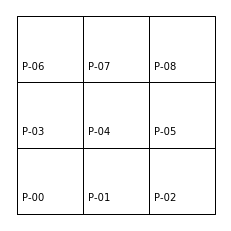

In [83]:
ax = gdf.plot(facecolor='w', edgecolor='k')
[plt.text(x, y, t, 
          verticalalignment='center',
          horizontalalignment='center') for x, y, t in zip(
         [p.centroid.x-.25 for p in polys],
         [p.centroid.y-.25 for p in polys],
         [i for i in gdf['id']])]
ax.set_axis_off()
plt.show()

A common way to express contiguity/adjacency relationships arises from an analogy to the legal moves that different chess pieces can make. *Rook* contiguity requires that the pair of polygons in
question share an *edge*. According to this definition, polygon $0$ would be a rook neighbor of $1$ and $3$, while $1$ would be a rook neighbor with $0$, $2$, and $4$. Applying this rule to all 9 polygons we can model our neighbor relations as:

In [84]:
# do a regular 3x3 lattice and draw it here
w = weights.contiguity.Rook.from_dataframe(gdf)
w.neighbors

{0: [1, 3],
 1: [0, 2, 4],
 2: [1, 5],
 3: [0, 4, 6],
 4: [1, 3, 5, 7],
 5: [8, 2, 4],
 6: [3, 7],
 7: [8, 4, 6],
 8: [5, 7]}

Shown visually, we can see this plotted on top of the same grid of labelled polygons, using red dotted lines showing connetions between the polygons:

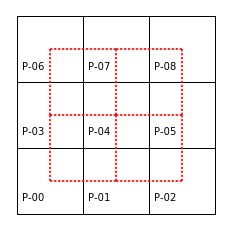

In [85]:
f,ax = plt.subplots(1,1, subplot_kw=dict(aspect='equal'))
w.plot(gdf, edge_kws=dict(color='r', linestyle=':'), ax =ax)
gdf.plot(facecolor='w', edgecolor='k', ax=ax)
[ax.text(x, y, t, 
          verticalalignment='center',
          horizontalalignment='center') for x, y, t in zip(
         [p.centroid.x-.25 for p in polys],
         [p.centroid.y-.25 for p in polys],
         [i for i in gdf['id']])]
plt.gca().set_axis_off()

The  `neighbors` attribute of our PySAL $W$ object encodes the neighbor
relationships by expressing the *focal* observation on the left (in the `key` of the dictionary), and expressing the *neighbors* to the *focal* in the list on the right (in the `value` of the dictionary). This representation has computational advantages as it exploits
the sparse nature of contiguity weights matrices. 

More specifically, knowing
that the neighbors of polygon $0$ are $3$ and $1$ implies that polygons $2, 4,
5, 6, 7, 8$ are not Rook neighbors of 0. As such, there is no reason to store
the "non-neighbor" information and this results in significant reductions in
memory requirements. However, it is possible to create the fully dense
representation if needed:

In [86]:
pandas.DataFrame(*w.full()).astype(int)

,0,1,2,3,4,5,6,7,8
0,0,1,0,1,0,0,0,0,0
1,1,0,1,0,1,0,0,0,0
2,0,1,0,0,0,1,0,0,0
3,1,0,0,0,1,0,1,0,0
4,0,1,0,1,0,1,0,1,0
5,0,0,1,0,1,0,0,0,1
6,0,0,0,1,0,0,0,1,0
7,0,0,0,0,1,0,1,0,1
8,0,0,0,0,0,1,0,1,0


As you can see from the matrix above, most entries are zero. In fact out of all of the possible $9^2=81$ linkages that there could be in this matrix, there are only twenty-four:

In [87]:
w.nonzero

24

Thus, we can save a significant amount of memory and lose no information by storing these sparse representations, which only record the non-zero values. 

More generally, the spatial weights for our 3-by-3 grid can be represented as a matrix that has 9 rows and 9 columns, matching the number of polygons $(n=9)$. An important thing to note is that geography has more than one dimension. When compared to common representations of relationships *in time* used in data science, using information about spatial relationships can be more complex: spatial relationships are bi-directional, while temporal relationships are unidirectional. Further complicating things, the ordering of the observations in the weights matrix is ambiguous. The first row is not first for a specific reason. Here we simply use the alphanumeric ordering of the unit identifiers to match a polygon with a row or column of the matrix, but any arbitrary rule could be followed and the weights matrix would look different. The graph, however, would be isomorphic.. 

Spatial weights matrices may look familiar to those acquainted with social
networks and graph theory in which **adjacency** matrices play a central role in
expressing connectivity between nodes. Indeed, spatial weights matrices can be
understood as a graph adjacency matrix where each observation is a node and
the spatial weight assigned between a pair represents the weight of the edge on
a graph connecting the arcs. Sometimes, this is called the **dual graph** or **line graph** of the input geographic data. This is advantageous as geographic data science can
borrow from the rich graph theory literature. At the same time, spatial
data has numerous distinguishing characteristics that necessitate the
development of specialized procedures and concepts in the handling of spatial
weights. In this chapter we will cover many of these features.

A close inspection of our graph reveals that the Rook contiguity criterion actually places
a restriction on the spatial relation. More specifically, polygons $0$ and $5$
are not Rook neighbors, but they do in fact share a common border. However, in
this instance the sharing is due to a common *vertex* rather than a shared
*edge*. This leads to the more inclusive notion of *Queen* contiguity that
requires the pair of polygons to only share one or more *vertices*. We can create the
neighbor relations for this same configuration as follows:

In [88]:
# do a regular 3x3 lattice and draw it here
w = weights.contiguity.Queen.from_dataframe(gdf)
w.neighbors

{0: [1, 3, 4],
 1: [0, 2, 3, 4, 5],
 2: [1, 4, 5],
 3: [0, 1, 4, 6, 7],
 4: [0, 1, 2, 3, 5, 6, 7, 8],
 5: [1, 2, 4, 7, 8],
 6: [3, 4, 7],
 7: [3, 4, 5, 6, 8],
 8: [4, 5, 7]}

In addition to this neighbors representation, we can also express the graph visually, as done before:

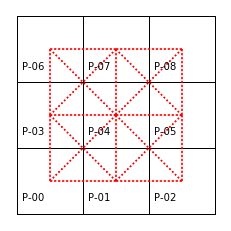

In [89]:
f,ax = plt.subplots(1,1, subplot_kw=dict(aspect='equal'))
w.plot(gdf, edge_kws=dict(color='r', linestyle=':'), ax =ax)
gdf.plot(facecolor='w', edgecolor='k', ax=ax)
[ax.text(x, y, t, 
          verticalalignment='center',
          horizontalalignment='center') for x, y, t in zip(
         [p.centroid.x-.25 for p in polys],
         [p.centroid.y-.25 for p in polys],
         [i for i in gdf['id']])]
plt.gca().set_axis_off()

By using `Contiguity.Queen` rather than `Contiguity.Rook`, we consider observations that share a vertex to be neighbors. The result is that the neighbors of $0$ now include $4$ along with $3$ and $1$.

Like the `neighbors` dictionary encodes the contiguity relations, the `weights` dictionary encodes the strength of the link connecting the focal to each neighbor. For contiguity
weights, values are usually binary and, as in any `PySAL` `W` object, contained in its
`weights` attribute:

In [90]:
w.weights

{0: [1.0, 1.0, 1.0],
 1: [1.0, 1.0, 1.0, 1.0, 1.0],
 2: [1.0, 1.0, 1.0],
 3: [1.0, 1.0, 1.0, 1.0, 1.0],
 4: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 5: [1.0, 1.0, 1.0, 1.0, 1.0],
 6: [1.0, 1.0, 1.0],
 7: [1.0, 1.0, 1.0, 1.0, 1.0],
 8: [1.0, 1.0, 1.0]}

Similar to the `neighbors` attribute, the `weights` object is a Python
dictionary that only stores the non-zero weights. Although the weights for a
given observations neighbors are all the same value for contiguity weights, it
is important to note that the `weights` and `neighbors` are aligned with one another; for each observation, its first neighbor in `neighbors` has the first weight in its `weights` entry. This will be important when we examine distance based weights further
on, when observations will have different weights. 

In addition to the `neighbor` and `weights` attributes, the `w` object has a
large number of other attributes and methods that can be useful. The
`cardinalities` attribute reports the number of neighbors for each observation:

In [91]:
w.cardinalities

{0: 3, 1: 5, 2: 3, 3: 5, 4: 8, 5: 5, 6: 3, 7: 5, 8: 3}

The related `histogram` attribute provides an overview of the distribution of
these cardinalities:

In [92]:
w.histogram

[(3, 4), (4, 0), (5, 4), (6, 0), (7, 0), (8, 1)]

We can obtain a quick visual representation by converting the cardinalities
into a `pandas.Series` and creating a histogram:

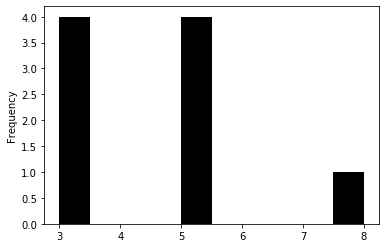

In [93]:
pandas.Series(w.cardinalities).plot.hist(color='k');

The `cardinalities` and `histogram` attributes help quickly spot asymmetries in
the number of neighbors. This, as we will see later in the book, is relevant
when using spatial weights in other analytical techniques (e.g.
spatial autocorrelation analysis or spatial regression). Here we see that there are four corner
observations with three neighbors, four edge observations with five neighbors,
and the one central observation has eight neighbors. There are also no
observations with four, six, or seven neighbors.

By convention, an ordered pair of contiguous observations constitutes a *join*
represented by a non-zero weight in a $W$. The attribute `s0` records the number
of joins.

In [94]:
w.s0

40.0

The `pct_nonzero` attribute provides a measure of the density (compliment of
sparsity) of the spatial weights matrix (if we had it stored explicitly, which
we don't):

In [95]:
w.pct_nonzero

49.382716049382715

which is equal to $100 \times (\texttt{w.s0} / \texttt{w.n}^2)$.

### Spatial Weights from real-world data

The regular lattice map encountered above helps us to understand the logic and
properties of PySAL's spatial weights class. However, the artificial nature of
that geography is of limited relevance to real world research problems.
Fortunately, PySAL supports the construction of spatial weights objects from a
number of commonly used spatial data formats. Here we demonstrate this
functionality for the case of census tracts in San Diego, California. Most spatial
data formats, such as shapefiles, are non-topological in that they encode the
polygons as a collection of vertices defining the edges of the geometry's
boundary. No information about the neighbor relations is explicitly encoded, so we
must construct it ourselves. Under the hood, PySAL uses efficient spatial indexing
structures to extract these.

In [96]:
san_diego_tracts = geopandas.read_file('../data/sandiego/sd_tracts_acs_clean.shp')
wq = weights.contiguity.Queen.from_dataframe(san_diego_tracts)

/home/serge/anaconda3/envs/gdsbook/lib/python3.6/site-packages/pysal/lib/weights/contiguity.py:185: UserWarning: There is one disconnected observation (no neighbors).
Island id: 103
  W.__init__(self, neighbors, ids=ids, **kw)


Note the warning about disconnected observations (no neighbors). The disconnected observation warning indicates that there are polygons in the shapefile that do not share any vertices with other polygons. Any time there is a disconnected observation, sometimes called a topological *island*, the graph is also disconnected into at least two one components. Further, graphs can have more than one disconnected component even without any islands. We will return to deal with this later in this chapter. For now we focus on the object just created.

Like before, we can visualize the adjacency relationships, but they are much more difficult to see without showing a closer detail:

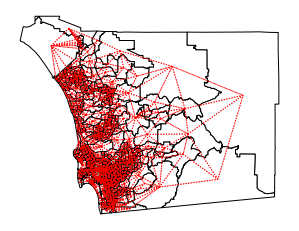

In [97]:
ax = san_diego_tracts.plot(edgecolor='k', facecolor='w')
wq.plot(san_diego_tracts, ax=ax, 
        edge_kws=dict(color='r', linestyle=':', linewidth=1),
        node_kws=dict(marker=''))
ax.set_axis_off()

So, showing more detail, we can get a glimpse of the complicated structure of the contiguity relationships between tracts in the center city:

[-13040000, -13020000, 3850000, 3860000]

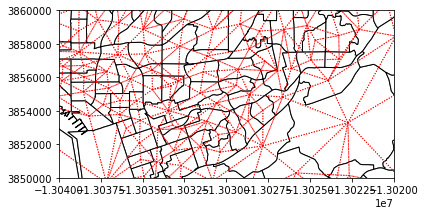

In [98]:
ax = san_diego_tracts.plot(edgecolor='k', facecolor='w')
f,ax = wq.plot(san_diego_tracts, ax=ax, 
        edge_kws=dict(color='r', linestyle=':', linewidth=1),
        node_kws=dict(marker=''))
ax.axis([-13040000,  -13020000, 3850000, 3860000])
#ax.set_axis_off()

The weights object for San Diego tracts have the same attributes and methods as
we encountered with our artificial layout above:

In [99]:
print(wq.n)
print(wq.pct_nonzero)

627
1.0067942074993195


First we have a larger number of spatial units. The spatial weights are
also much more sparse for the tracts than what we saw for our smaller toy
layout. Moreover, the cardinalities have a radically different distribution:

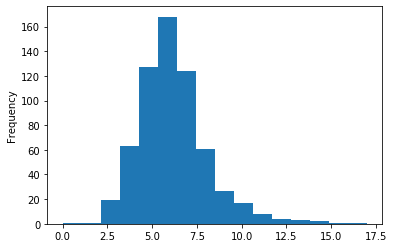

In [100]:
s = pandas.Series(wq.cardinalities)
s.plot.hist(bins=s.unique().shape[0]);

as the minimum number of neighbors is 0 (due to our disconnected observation), while there is one polygon with 17
queen neighbors. The most common number of neighbors is 6.

There is also a function to create the rook weights for the same dataframe:

0.8592599375777417


/home/serge/anaconda3/envs/gdsbook/lib/python3.6/site-packages/pysal/lib/weights/contiguity.py:34: UserWarning: There is one disconnected observation (no neighbors).
Island id: 103
  W.__init__(self, neighbors, ids=ids, **kw)


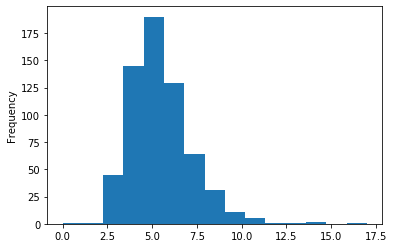

In [101]:
wr = weights.contiguity.Rook.from_dataframe(san_diego_tracts)
print(wr.pct_nonzero)
s = pandas.Series(wr.cardinalities)
s.plot.hist(bins=s.unique().shape[0]);

The cardinality histogram shifts downward due to the increasing sparsity of the
weights for the rook case relative to the queen criterion. Conceptually, this makes sense; all Rook neighbors are also Queen neighbors, since Queen includes neighbors that share an edge. But, not all Queen neighbors are Rook neighbors, since some Queen neighbors only share a point on their boundaries in common. 

The example above shows how the notion of contiguity, although more
straightforward in the case of a grid, can be naturally extended beyond the
particular case of a regular lattice. The principle to keep in mind is that we
consider contiguous (and hence call neighbours) observations which share part
of their border coordinates. In the queen case, a single point is enough to make
the join. For rook neighbours, we require a join to consist of one or more
shared edges. This distinction is probably less relevant in the real world that
in appears in the grid example above, and it is probably down to geocoding
issues rather than substantive differences. In any case, there are special cases
where this distinction can matter and it is useful to be familiar with the
differences between the two approaches and how to apply them.


We also see the same disconnected observation warning, so let's return to this
issue and explore it a bit further. PySAL indicates that the disconnected
observation has `id: 103`.

In [102]:
wr.islands

[103]

 Disconnected here means that this observation has no
neighbors according to the specific contiguity criterion. Checking the
`neighbors` attribute we see an empty list for this observation:

In [103]:
wr.neighbors[103]

[]

in contrast to say observation with `id: 10` which has six neighbors:

In [104]:
wr.neighbors[10]

[5, 214, 6, 9, 11, 12]

Disconnected observations, or islands, can cause problems for the spatial
analytics that rely on spatial weights. As such, there are different approaches
to deal with these observations so that they are no longer disconnected. One
approach relies on the notion of nearest neighbor weights, which we turn to
next.

## Distance Based Weights

In addition to contiguity, we can also define neighbor relations as a function of
the distance separating spatial observations. Usually, this means that a matrix expressing the distances between all pairs of observations are required. These are then provided to a **kernel** function which uses the proximity information to model proximity as a smooth function of distance. PySAL implements a family of
distance functions. Here we illustrate a selection beginning with the notion
of *nearest neighbor* weights.

### Knn weights

The first type of distance based weights defines the neighbor set of a
particular observation as containing its nearest $k$ observations, where the
user specifies the value of value $k$. To illustrate this for the San Diego
tracts we take $k=4$. This still leaves the issue of how to measure the distance
between these polygon objects, however. To do so we develop a representative
point for each of the polygons using the so called "center of mass" or centroid.

In [105]:
wk4 = weights.distance.KNN.from_dataframe(gdf, k=4)

The centroids are attributes of the polygon shapes that PySAL calculates from
the spatial information stored in the `GeoDataFrame`. Since we are dealing with
polygons in this case, PySAL uses inter-centroid distances to distance determine the
$k$ nearest observations to each polygon. 

The knn weights solve our island problem:

In [106]:
wk4.islands

[]

however, examination of the cardinality histogram for the knn weights shows us
that each observation has the same number of neighbors:

In [107]:
wk4.histogram

[(4, 9)]

This is by construction as the feature is at the very heart of the
KNN approach. In some cases, this is not an issue but a desired feature. In
other contexts, however, this characteristic of KNN weights can be undesirable.
In such situations, we can turn to other types of distance-based weights.

### Kernel weights

The knn rule assigns binary values to the weights for neighboring observations.
PySAL also supports continuously valued weights to reflect Tobler's first law
[1] in a more direct way: observations that are close to a unit have larger
valued weights than more distant observations.

Kernel weights are one of the most commonly-used kinds of distance weights. They
reflect the case where similarity/spatial proximity is assumed or expected to
decay with distance. The essence of kernel weights is that the weight between
observations $i$ and $j$ is based on their distance, but this is modulated by
a kernel function with certain properties. PySAL implements several kernels.
All of them share the properties of distance decay (thus encoding Tobler's First 
Law), but may decay at different rates with respect to distance.

As a computational note, it is worth mentioning that many of these distance-based deacy functions require more computation than the contiguity weights or K-nearest neighbor weights discussed above. This is because the contiguity & KNN structures embed simple assumptions about how shapes relate in space, while kernel functions relax several of those assumptions. Thus, they provide more flexibility at the expense of computation.

The simplest way to compute Kernel weights in PySAL involves a single function
call:

In [108]:
w_kernel = weights.distance.Kernel.from_dataframe(gdf)

Like KNN weights, the Kernel weights are based on distances between observations. By default, if the input data is an areal unit, we use a central representative point (like the centroid) for that polygon.
The value of the weights will be a function of two main options for
kernel weights: choice of kernel function; and the bandwidth. The
former controls how distance between $i$ and $j$ is "modulated" to produce a
the weight that goes in $w_{ij}$. In this respect, PySAL offers a large number
of functions that determine the shape of the distance
decay function. The bandwidth specifies the distance from each focal unit over which
the kernel function is applied. For observations separated by distances larger
than the bandwidth, the weights are set to zero.

The default values for kernels are to use a triangular kernel with a bandwidth distance
equal to the maximum knn=2 distance
for all observations. The latter implies a so-called fixed bandwidth were all
observations use the same distance for the cut-off. We can inspect this from
the generated `W` object:

In [109]:
w_kernel.function

'triangular'

for the kernel function, and:

In [110]:
w_kernel.bandwidth[0:5]

array([[1.0000001],
       [1.0000001],
       [1.0000001],
       [1.0000001],
       [1.0000001]])

For the bandwith applied to each observation.

Although simple, a fixed bandwith is not always the best choice. For example,
in cases where the density of the observations varies over the study region,
using the same threshold anywhere will result in regions with a high density
of neighbors while others with observations very sparsely connected. In these
situations, an *adaptive* bandwith -one which varies by observation and its
characteristics- can be preferred. Adaptive bandwidths are picked again using a K-nearest neighbor rule. A bandwidth for each observation is chosen such that, once the $k$-nearest observation is considered, all the remaining observations have zero weight.

For example, using the first ten tracts in our San Diego tract data, we can see that the centroids of each tract are not exactly regularly-spaced, although others do nearly fall into a regular spacing:

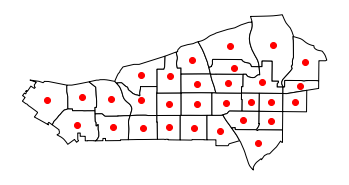

In [111]:
top_30 = san_diego_tracts.head(30)
ax = top_30.plot(facecolor='w', edgecolor='k')
ax = top_30.head(30).centroid.plot(color='r', ax=ax)
ax.set_axis_off()

We can see that the adaptive bandwidth adjusts for this:

In [112]:
w_adaptive = weights.distance.Kernel.from_dataframe(top_30, fixed=False, k=15)
w_adaptive.bandwidth

array([[7065.75104957],
       [5728.46240793],
       [5766.83702384],
       [4334.37049483],
       [4596.75793866],
       [3614.26794702],
       [3406.31834666],
       [3483.32856325],
       [3001.91264191],
       [2980.82767647],
       [2999.52550684],
       [3067.19959966],
       [2352.5156947 ],
       [2528.14492198],
       [2891.45948781],
       [2999.52550684],
       [2317.82469203],
       [2389.45906482],
       [2753.7624947 ],
       [3407.76610407],
       [3896.97847546],
       [4411.6620426 ],
       [2598.6627804 ],
       [2480.73728866],
       [2996.084241  ],
       [4123.83777069],
       [3965.08200809],
       [3001.91264191],
       [3112.19094718],
       [3659.29224551]])

And, we can visualize what these kernels look like on the map, too, by focusing on an individual unit and showing how the distance deacy attenuates the weight by grabbing the corresponding row of the full kernel matrix:

[None, None]

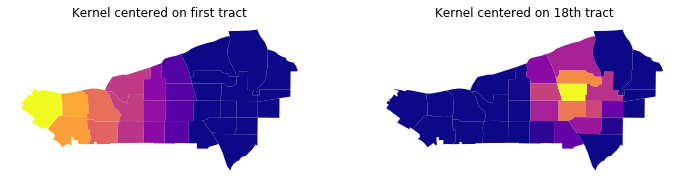

In [113]:
full_matrix, ids = w_adaptive.full() 
f,ax = plt.subplots(1,2,figsize=(12,6), subplot_kw=dict(aspect='equal'))
top_30.assign(weight_0 = full_matrix[0]).plot("weight_0", cmap='plasma', ax=ax[0])
top_30.assign(weight_15 = full_matrix[17]).plot("weight_15", cmap='plasma', ax=ax[1])
ax[0].set_title("Kernel centered on first tract")
ax[1].set_title("Kernel centered on 18th tract")
[ax_.set_axis_off() for ax_ in ax]

What the kernel looks like can be strongly affected by the structure of spatial proximity, so any part of the map can look quite different from any othe rpart of the map. By imposing a clear distance decay over several of the neighbors of each observation,
kernel weights incorporate Tobler's law very explicitly. Often, this comes at the cost of
increased memory requirements, as every single pair of observations within the
bandwidth distance is considered:

In [114]:
w_kernel.pct_nonzero

40.74074074074074

In many instances, this may be at odds with the nature of the spatial
interactions at hand, which operate over a more limited range of distance. In
these cases, expanding the neighborhood set beyond might lead us to consider
interactions which either do not take place, or are inconsequential. Thus, for
both substantive and computational reasons, it might make sense to further
limit the range, keeping impacts to be hyper-local.

## Distance bands and hybrid Weights

In some contexts, it makes sense to draw a circle around each observation and
consider as neighbors every other observation that falls within the circle.
In the GIS terminology, this is akin to drawing a buffer around each point and
performing a point-in-polygon operation that determines whether each of the
other observations are within the buffer. If they are, they are assigned a
weight of one in the spatial weights matrix, if not they receive a zero.

In [115]:
w_bdb = weights.distance.DistanceBand.from_dataframe(gdf, 1.5, binary=True)

This creates a binary distance weights where every other observation within
a distance of 1.5 is considered neighbor.

Hybrid weights, also available in PySAL, are matrices that
offer a blend of the threshold and continuous distance weights by truncating the
neighbor pairs to those separated by less than some distance threshold.

Let us for instance calculate a hybrid matrix that combines inverse distance
weights up to a certain threshold and then truncate the weights to zero for
everyone else. For this example we will return to the small lattice example
covered in the beginning:

In [116]:
w_hy = weights.distance.DistanceBand.from_dataframe(gdf, 1.5, binary=False)

We apply a threshold of 1.5 for this illustration. PySAL truncates continuous
weights at this distance. It is important to keep in mind that the threshold
distance must use the same units of distance as the units used to define the
matrix.

We can inspect the `weights` dictionary to see the weights, in this case, are
not 1 or 0 only, but there are values in-between:

In [117]:
w_hy.weights

{0: [1.0, 1.0, 0.7071067811865475],
 1: [1.0, 1.0, 0.7071067811865475, 1.0, 0.7071067811865475],
 2: [1.0, 0.7071067811865475, 1.0],
 3: [1.0, 0.7071067811865475, 1.0, 1.0, 0.7071067811865475],
 4: [0.7071067811865475,
  1.0,
  0.7071067811865475,
  1.0,
  1.0,
  0.7071067811865475,
  1.0,
  0.7071067811865475],
 5: [0.7071067811865475, 1.0, 1.0, 0.7071067811865475, 1.0],
 6: [1.0, 0.7071067811865475, 1.0],
 7: [0.7071067811865475, 1.0, 0.7071067811865475, 1.0, 1.0],
 8: [0.7071067811865475, 1.0, 1.0]}

which contrasts with the original weights:

In [118]:
w.weights

{0: [1.0, 1.0, 1.0],
 1: [1.0, 1.0, 1.0, 1.0, 1.0],
 2: [1.0, 1.0, 1.0],
 3: [1.0, 1.0, 1.0, 1.0, 1.0],
 4: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 5: [1.0, 1.0, 1.0, 1.0, 1.0],
 6: [1.0, 1.0, 1.0],
 7: [1.0, 1.0, 1.0, 1.0, 1.0],
 8: [1.0, 1.0, 1.0]}

### Great Circle distances

We must make one final curve before leaving the distance based weights. It is important that the
calculation of distances between objects takes the curvature of the Earth's
surface into account. This can be done before computing the spatial weights object, 
by transforming the coordinates of data points into a projected reference system, in 
a GIS, for example. If 
this is not possible or convenient, an approximation that considers the
curvature implicit in non-projected reference systems (e.g.
longitude/latitude) can be a sufficient workaround. PySAL provides such
approximation as part of its functionality.

To illustrate the relevance of ignoring this aspect altogether we will examine
distance based weights for the case of counties in the state of Texas. First, let us compute
a KNN-4 object that ignores the curvature of the Earth's surface:

In [119]:
texas = geopandas.read_file('../data/texas.shp')
knn4_bad = weights.distance.KNN.from_dataframe(texas, k=4) # ignore curvature of the earth

In [120]:
knn4_bad.histogram

[(4, 254)]

Next, let us take curvature into account. To do this, we require the
radious of the Earth expressed in a given metric. PySAL provides this number
in both miles and kilometres. For the sake of the example, we will use miles:

In [121]:
radius = geometry.sphere.RADIUS_EARTH_MILES
radius

3958.755865744055

With this measure at hand, we can pass it to the weights constructor (either
straight from a shapefile or from a `GeoDataFrame`) and distances will be
expressed in the units we have used for the radious, that is in miles in our
case:

In [122]:
knn4 = weights.distance.KNN.from_dataframe(texas, k=4, radius=radius)

In [123]:
knn4.histogram

[(4, 254)]

Comparing the resulting neighbor sets, we see that ignoring the curvature of the
Earth's surface can create erroneous neighbor pairs:

In [124]:
knn4[0]

{6: 1.0, 4: 1.0, 5: 1.0, 3: 1.0}

In [125]:
knn4_bad[0]

{6: 1.0, 4: 1.0, 5: 1.0, 13: 1.0}

## Set Operations on Weights

So far, we have seen different principles that guide how to build spatial
weights matrices. In this section, we explore how we can create new matrices
by *combining* different existing ones. This is useful in contexts where a
single neighborhood rule has flaws or when theory or other guiding principles
point in directions that require combining more than a single criterium.

We will explore these ideas in the section by returning to the problem we
faced above of an island observation encountered
when constructing the weights for the San Diego tracts. A number of ways exist 
to solve this island problem through a combination of the original contiguity
weights and the nearest neighbor weights. We will examine two different
approaches that provide the same solution, thus illustrating the value of set
operations in PySAL.

### Editing/connecting disconnected observations

The first approach we adopt is to find the nearest neighbor for the island observation
and then add this pair of neighbors to extend the neighbor pairs from the
original contiguity weight to obtain a fully connected set of weights. Recall that our tract shapefile in San Diego had a disconnected observation, number 103. For us to reattach this tract, we can assign it to be "connected" to its nearest neighbor. 

But, since this is real data, we might want to take a look first by plotting our disconnected tract in red on top of the existing tracts. To do this, let's first extract our "problem" geometry:

In [126]:
disconnected_tract = san_diego_tracts.iloc[[103]]

build a good "viewing" window around this polygon by *buffering* it, giving a good context around the focal unit of observation:

In [127]:
buffer = disconnected_tract.geometry.buffer(2000)
west, south, east, north = buffer.bounds.values[0]

Then, we can make a plot of the tracts, zooming into the frame established by our buffer:

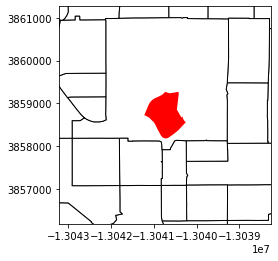

In [128]:
ax = san_diego_tracts.plot(facecolor='w', edgecolor='k')
ax = disconnected_tract.plot(ax=ax, color='red')
ax.axis([west, east, south, north])
plt.show()

From this, we can see *why* our tract is disconnected, rather than simply *that* it is disconnected. The larger square tract *contains* the tract above, our island. Conceptually, they sit on top of one another rather than touching one another. Since they do not share any vertices on their boundaries in common (since the polygon below entirely contains the polygon above), they do not actually *touch* using our definition of contiguity. 

That aside, we can still re-attach the observation to the graph by connecting it to its nearest neighbor. To do this, we can construct the KNN graph as we did above, but set `k=1`, so observations are only assigned to their nearest neighbor:

In [129]:
wk1 = weights.distance.KNN.from_dataframe(san_diego_tracts, k=1)

/home/serge/anaconda3/envs/gdsbook/lib/python3.6/site-packages/pysal/lib/weights/weights.py:170: UserWarning: The weights matrix is not fully connected. There are 154 components
  warnings.warn("The weights matrix is not fully connected. There are %d components" % self.n_components)


In this graph, all our observations are connected to *at least* one other observation, so island observation is connected to:

In [130]:
wk1.neighbors[103]

[104]

To attach our island, we need to create a copy of the `neighbors` dictionary and update the entry for `103`, giving it `104` as a neighbor. So, first we copy the neighbors:

In [131]:
neighbors = wr.neighbors.copy()

and then we are change the entry for the island observation to include its
nearest neighbor (`104`) as well as update `104` to have `103` as a neighbor:

In [132]:
neighbors[103].append(104)
neighbors[104].append(103)
w_fixed = weights.W(neighbors)
print(w_fixed.islands)
print(w_fixed.histogram)

[]
[(1, 1), (2, 1), (3, 45), (4, 145), (5, 190), (6, 129), (7, 64), (8, 25), (9, 6), (10, 11), (11, 5), (12, 1), (13, 1), (14, 1), (15, 1), (16, 0), (17, 1)]


now, when we visualize the graph in the area around our island:

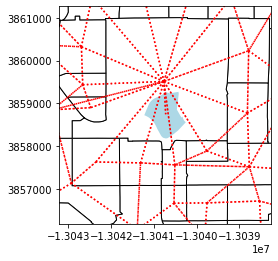

In [133]:
f,ax = w_fixed.plot(san_diego_tracts, edge_kws=dict(color='red', linestyle=':'))
ax = san_diego_tracts.plot(facecolor='w', edgecolor='k', ax = ax)
ax = disconnected_tract.plot(ax=ax, color='lightblue')
ax.axis([west, east, south, north])
plt.show()

We can see that our island is now connected to its nearest neighbor, which happens to *also* be the observation which contains it. 

### Using the `union` of matrices

A more elegant approach to the island problem makes use of PySAL's support for
*set theoretic operations* on PySAL weights:

In [134]:
w_fixed_sets = weights.set_operations.w_union(wr, wk1)
w_fixed_sets.histogram

[(1, 1),
 (2, 1),
 (3, 45),
 (4, 145),
 (5, 188),
 (6, 131),
 (7, 64),
 (8, 25),
 (9, 6),
 (10, 11),
 (11, 5),
 (12, 1),
 (13, 1),
 (14, 1),
 (15, 1),
 (16, 0),
 (17, 1)]

It is important to mention that this approach is not exactly the same, at least
in principle, as the one above. It could be that the nearest
observation was not originally a neighbor and, in this case, the resulting
matrices would differ. This is a rare but theoretically possible situation.

### Block Weights

A final type of spatial weight we examine here are block weights. Membership in
a group or set defines the neighbor relationships. Block weights connect every
observation in a data set that belongs to the same category in a list provided
*ex-ante*. Usually, this list will have some relation to geography 
of the observations but, technically speaking, all one needs to create block
weights is a list of memberships. In essence, a hierarchical structure groups
individual observations and assigns a value of one to the weight for all
pair-members of the group, and a value of zero to pairs involving observations
belonging to different groups.


To demonstrate this class of spatial weights, we will use the tract dataset for
San Diego and focus on their county membership:

In [135]:
san_diego_tracts[['GEOID', 'state', 'county', 'tract']].head()

,GEOID,state,county,tract
0,06073000100,06,073,000100
1,06073000201,06,073,000201
2,06073000202,06,073,000202
3,06073000300,06,073,000300
4,06073000400,06,073,000400


Every tract has a unique ID (`GEOID`) and a county ID, shared by all tracts in
the same county. Since the entire region of San Diego is in California, the
state ID is the same across the dataset.

To build a block weights matrix, we do not even need spatial data beyond the
list of memberships. In this case, we will use the county membership:

In [136]:
# NOTE: since this is a large dataset, it might take a while to process
w_bl = weights.util.block_weights(san_diego_tracts['county'].values, 
                                  ids=san_diego_tracts['GEOID'].values)

As a check, let's consider the first two rows in the table above. If the block
weights command has worked out correctly, both should be neighbors:

In [137]:
'06073000201' in w_bl['06073000100']

True

We can use block weights as an intermediate step in more involved analyses
of spatial linkages. Suppose for example, the researcher wanted to allow for
queen neighbors within counties but not for tracts across different counties.
Tracts from different counties are not considered neighbors. To create such
as spatial weights matrix would require a combination of the queen and the block
criteria, and PySAL can implement that blending through one of the set operations.


### Visualizing weight set operations

We finish the chapter by illustrating the concepts above using 
the 32 states of Mexico. We compare the neighbor graphs that results
from the different criteria used to define neighbor relations. The graphs are
constructed by specifying the nodes at the polygon centroids for each of the
states. Edges are then drawn between a pair of nodes to reflect a neighbor
relation between the states according to the specific definition.

We first read in the data for Mexico:

In [ ]:

mx = geopandas.read_file('../data/mexicojoin.shp')
f, ax = plt.subplots(1, figsize=(9, 9))
mx.plot(ax=ax)
ax.set_axis_off()
ax.set_title('Mexico States')
plt.axis('equal')
plt.show()

We will contrast the connectivity structure for the three following types of spatial weights:

- Queen contiguity weights
- Block weights
- Combination of Block+Queen weights


Beginning with Queen weights:

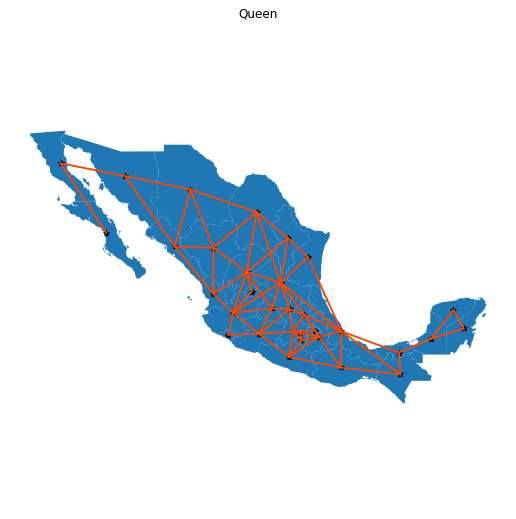

In [139]:
queen_mx = weights.contiguity.Queen.from_dataframe(mx)
f, ax = plt.subplots(1, figsize=(9, 9))
mx.plot(ax=ax)
queen_mx.plot(mx,edge_kws=dict(linewidth=1.5, color='orangered'), node_kws=dict(marker='*'),  ax=ax, )
ax.set_axis_off()
ax.set_title('Queen')
plt.axis('equal')
plt.show()

For the block weights, we use the official designation of regions from the federal government:

/home/serge/anaconda3/envs/gdsbook/lib/python3.6/site-packages/pysal/lib/weights/weights.py:170: UserWarning: The weights matrix is not fully connected. There are 5 components
  warnings.warn("The weights matrix is not fully connected. There are %d components" % self.n_components)


Text(0.5, 1, 'Mexican Regions')

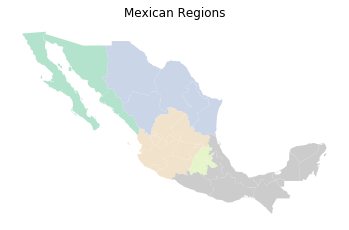

In [140]:
ax = mx.plot(column='INEGI2', categorical=True, cmap='Pastel2')
block_mx = weights.util.block_weights(mx['INEGI2'].values)
ax.set_axis_off()
ax.set_title("Mexican Regions")

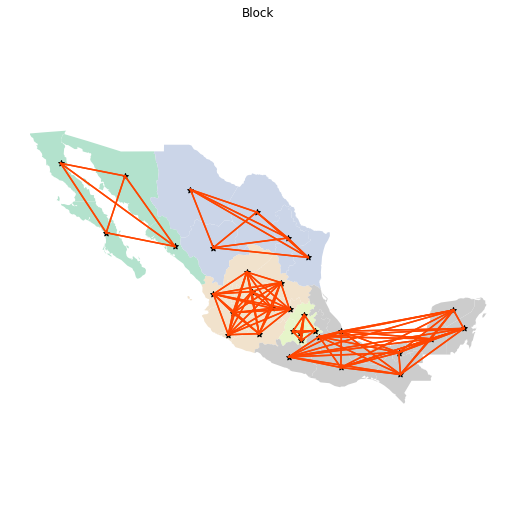

In [141]:
f, ax = plt.subplots(1, figsize=(9, 9))
mx.plot(column='INEGI2', categorical=True, 
        cmap='Pastel2', ax=ax)
block_mx.plot(mx, edge_kws=dict(linewidth=1.5, 
                                color='orangered'), 
                  node_kws=dict(marker='*'), ax=ax)
ax.set_axis_off()
ax.set_title('Block')
plt.axis('equal')
plt.show()

Next, we construct the union of queen contiguity and block weights

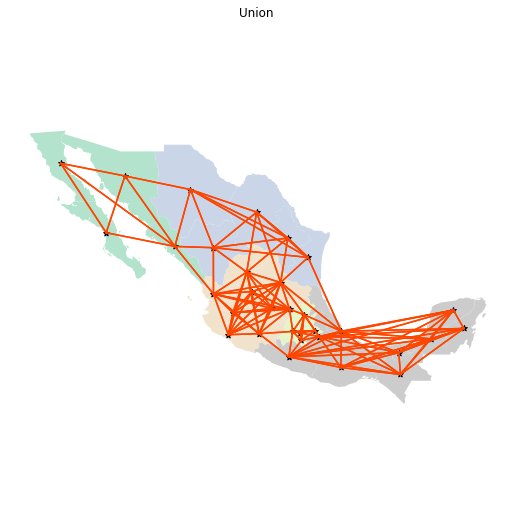

In [142]:
union_mx = weights.set_operations.w_union(block_mx, queen_mx)

f, ax = plt.subplots(1, figsize=(9, 9))
mx.plot(column='INEGI2', categorical=True, cmap='Pastel2', ax=ax)
union_mx.plot(mx, edge_kws=dict(linewidth=1.5, 
                                color='orangered'), 
              node_kws=dict(marker='*'), ax=ax)
ax.set_axis_off()
ax.set_title('Union ')
plt.axis('equal')
plt.show()

Finally, we compare the three neighbor graphs side by side:

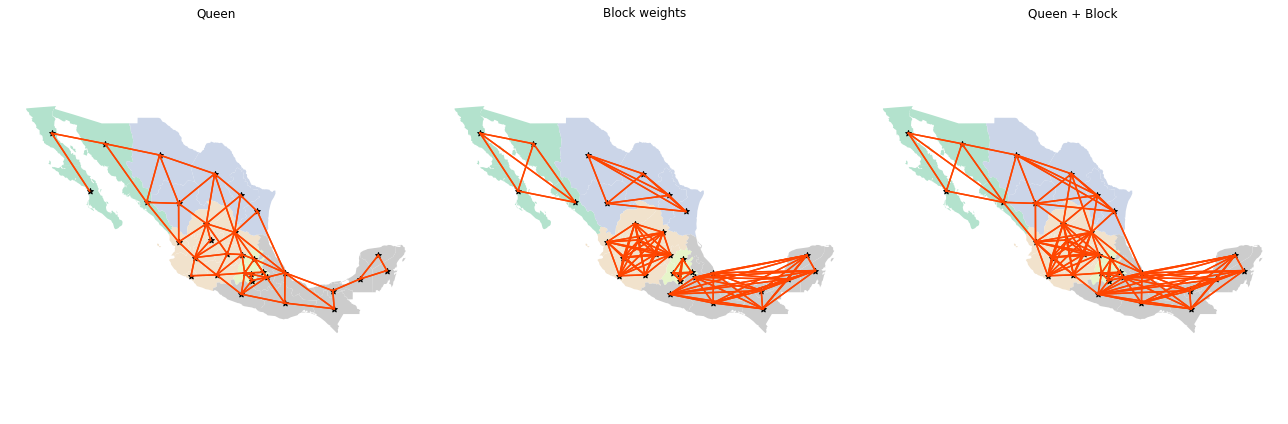

In [143]:
f, axs = plt.subplots(1, 3, figsize=(18, 6))


# Contiguity
ax = axs[0]
mx.plot(column='INEGI2', categorical=True, 
        cmap='Pastel2', ax=ax)
queen_mx.plot(mx, edge_kws=dict(linewidth=1.5, color='orangered'), 
              node_kws=dict(marker='*'), ax=ax)
ax.set_axis_off()
ax.set_title('Queen')
ax.axis('equal')

# Block
ax = axs[1]
mx.plot(column='INEGI2', categorical=True, 
        cmap='Pastel2', ax=ax)
block_mx.plot(mx, edge_kws=dict(linewidth=1.5, color='orangered'), 
              node_kws=dict(marker='*'), ax=ax)
ax.set_axis_off()
ax.set_title('Block weights')
ax.axis('equal')

# Union
ax = axs[2]
mx.plot(column='INEGI2', categorical=True, 
        cmap='Pastel2', ax=ax)
union_mx.plot(mx, edge_kws=dict(linewidth=1.5, color='orangered'), 
              node_kws=dict(marker='*'), ax=ax)
ax.set_axis_off()
ax.set_title('Queen + Block')
plt.axis('equal')
f.tight_layout()
plt.show()

Focusing on the Queen and Block graphs, there are clear distinctions between the
connectivity structures. The Block graph is visually more dense in particular areas relative to the
Queen graph and this is borne out in their sparsity measures:

In [144]:
block_mx.pct_nonzero

19.140625

In [145]:
queen_mx.pct_nonzero

13.4765625

The other distinguishing characteristic can be seen in the number of connected
components in the different graphs. The Queen graph has a single connected
component - which in graph theory terms, means for all pairs of states there is
at least one path of edges that connects the two states. The Block graph has
five connected components, one for each of the five regions. Moreover, each of
these connected components is fully-connected, meaning there is an edge that
directly connects each pair of member states. However, there are no edges
between states belonging to different blocks (or components).


As we will see in later chapters, certain spatial analytical techniques require
a fully connected weights graph. In these cases, we could adopt the Queen
definition since this satisfies the single connected component requirement.
However, we may wish to use the Union weights graph as that provides a single
connected component, but offers a blend of different types of connectivity
intensities, with the intra-regional (block) linkages being very dense, while
the inter-regional linkages are thinner but provide for the single connected
component.

## Use case: Boundary detection

Spatial weights are ubiquitous in the analysis of spatial patterns in data, since they provide a direct method to represent spatial structure. 
However, spatial weights are sometimes useful in their own right, such as when examining latent structures directly in the graphs themselves or when using them to conduct descriptive analysis. 
One clear use case that arises in the analysis of social data is to characterize latent *data discontinuities*. By *data discontinuity*, we mean a single border (or collection of borders) where data for a variate (or many variates) of interest change rapidly. 
These can be used in stochastic models of boundaries [2-4] or used to adapt classic empirical outlier detection methods. 
Below, we'll show one model-free way to identify empirical boundaries in your data. 

First, let's consider the median household income for our census tracts in San Diego:

In [146]:
from booktools import choropleth

Text(0.5, 1, 'Median Household Income')

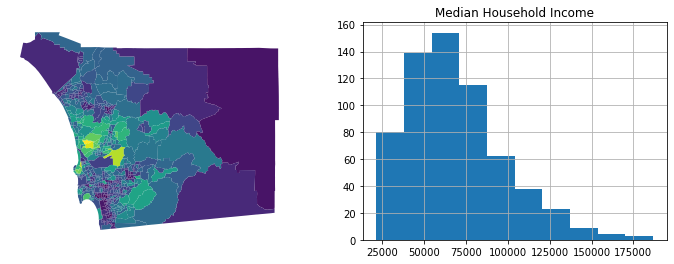

In [147]:
f,ax = plt.subplots(1,2, figsize=(12,4))
san_diego_tracts.plot('Median HH', ax=ax[0])
ax[0].set_aspect('equal')
ax[0].set_axis_off()
san_diego_tracts['Median HH'].hist(ax=ax[1])
ax[1].set_title("Median Household Income")

Now, we see some cases where there are very stark differences between neighboring areas, and some cases where there are essentially no difference between adjacent areas. Digging into this, we can examine the *distribution of differences* in neighboring areas using the adjacency list:

In [148]:
adjlist = wr.to_adjlist() 
adjlist.head()

,focal,neighbor,weight
0,0,112,1.0
1,0,1,1.0
2,0,2,1.0
3,0,203,1.0
4,1,0,1.0


This provides us with a table with three columns. `Focal` is the column containing the "origin" of the link, `neighbor` is the column containing the "destination" of the link, and `weight` contains how strong the link from `focal` to `neighbor` is. Since our weights are *symmetrical*, this table contains two entries per pair of neighbors, one for `(focal,neighbor)` and the other for `(neighbor,focal)`. Using this table and `pandas`, we can merge up the focal units' & neighboring units' median household incomes:

In [149]:
adjlist_wealth = adjlist.merge(san_diego_tracts[['Median HH']], how='left', 
                               left_on='focal', right_index=True)\
                        .merge(san_diego_tracts[['Median HH']], how='left',
                               left_on='neighbor', right_index=True, 
                               suffixes=('_focal', '_neighbor'))
adjlist_wealth.head()

,focal,neighbor,weight,Median HH_focal,Median HH_neighbor
0,0,112,1.0,125370.0,36686.0
1,0,1,1.0,125370.0,100436.0
2,0,2,1.0,125370.0,60929.0
3,0,203,1.0,125370.0,57642.0
4,1,0,1.0,100436.0,125370.0


Now, we have the wealth at both the focal observation and the neighbor observation. The difference between these two columns provides us every pairwise difference between *adjacent* tracts:

In [150]:
adjlist_wealth['diff'] = adjlist_wealth['Median HH_focal'] - adjlist_wealth['Median HH_neighbor']

With this difference information we can do a few things. First, we can compare whether or not this *distribution* is distinct from the distribution of non-neighboring tracts' differences in wealth. 

To do this, we can first compute the all-pairs differences in wealth using the `numpy.subtract` function. Some functions in numpy have special functionality; these `ufuncs` (short for "universal functions") often support special applications to your data. Here, we will use `numpy.subtract.outer` to take the difference over the "outer cartesian product" of two vectors; in practice, this results in the subtraction of all of the combinations of the input vectors:

In [151]:
all_pairs = numpy.subtract.outer(san_diego_tracts['Median HH'], san_diego_tracts['Median HH'])

/home/serge/anaconda3/envs/gdsbook/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: outer method for ufunc <ufunc 'subtract'> is not implemented on pandas objects. Returning an ndarray, but in the future this will raise a 'NotImplementedError'. Consider explicitly converting the Series to an array with '.array' first.
  """Entry point for launching an IPython kernel.


Then, we need to filter out those cells of `all_pairs` that are neighbors. Fortunately, our weights matrix is *binary*. So, subtracting it from an $N \times N$ matrix of $1$s will result in the *complement* of our original weights matrix:

In [152]:
complement_wr = 1 - wr.sparse.toarray()

Using this compelement, we can filter the `all_pairs` matrix to only consider the differences in median household income for tracts that are not neighboring: 

In [153]:
non_neighboring_diffs = (complement_wr * all_pairs).flatten()

Now, we can compare the two distributions of the difference in wealth:

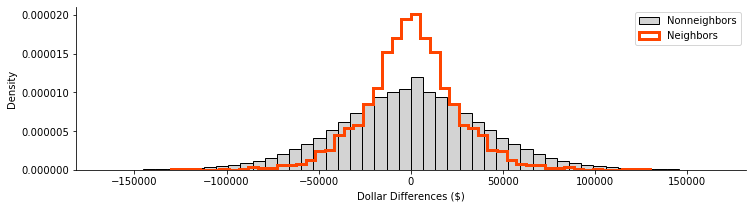

In [154]:
f = plt.figure(figsize=(12,3))
plt.hist(non_neighboring_diffs, color='lightgrey', 
         edgecolor='k', density=True, bins=50, label='Nonneighbors')
plt.hist(adjlist_wealth['diff'], 
         color='salmon', edgecolor='orangered', 
         linewidth=3, density=True, 
         histtype='step', bins=50, label='Neighbors')
seaborn.despine()
plt.ylabel("Density")
plt.xlabel("Dollar Differences ($)")
plt.legend()

From this, we can see that the two distributions are distinct, with the distribution of difference in *non-neighboring* tracts being slightly more dispersed than that for *neighboring* tracts. Thus, on the whole, this means that neighboring tracts have more *smaller differences in wealth* than nonneighboring tracts. This is consistent with the behavior we will talk about in later chapters concerning *spatial autocorrelation*, the tendency for observations to be statistically more similar to nearby observations than they are to distant observations. 

With this, we can then find our *most extreme* observed differences in wealth. Since our links are symmetric, the table sort is symmetric. So, we can focus only on focal observations with *the most extreme* difference in wealth from their immediate neighbors, focusing only on those where the *focal* is higher. 

In [155]:
extremes = adjlist_wealth.sort_values('diff', ascending=False).head(10)
extremes

,focal,neighbor,weight,Median HH_focal,Median HH_neighbor,diff
770,148,142,1.0,171094.0,41250.0,129844.0
767,148,180,1.0,171094.0,49050.0,122044.0
1144,219,217,1.0,168167.0,53173.0,114994.0
768,148,181,1.0,171094.0,69896.0,101198.0
2359,439,442,1.0,160694.0,70492.0,90202.0
0,0,112,1.0,125370.0,36686.0,88684.0
1139,219,423,1.0,168167.0,80038.0,88129.0
1147,219,412,1.0,168167.0,83295.0,84872.0
1145,219,443,1.0,168167.0,83316.0,84851.0
105,20,42,1.0,121518.0,37788.0,83730.0


Thus, we see that observation $148$ appears often on the the `focal` side, suggesting it's quite distinct from its nearby polygons. We also see observation $219$ often in the `focal` column. 

To verify whether these differences are truly beyond the pale, we can use a map randomization strategy. In this case, we shuffle the map and compute *new* `diff` columns. But, this time, `diff` represents the difference between random neighbors, rather than the neighbor structure we did observe, encoded in our Rook contiguity matrix. Using many `diff` vectors, we can find the observed differences which tend to be much larger than those encountered in randomly-drawn maps of household income.

So, to start, we can construct many random `diff` vectors:

In [156]:
n_simulations = 1000
simulated_diffs = numpy.empty((len(adjlist), n_simulations))
for i in range(n_simulations):
    median_hh_focal = adjlist_wealth['Median HH_focal'].values
    random_wealth = san_diego_tracts[['Median HH']].sample(frac=1, replace=False).reset_index()
    adjlist_random_wealth = adjlist.merge(random_wealth, left_on='focal', right_index=True)\
                                   .merge(random_wealth, left_on='neighbor', right_index=True, 
                                          suffixes=('_focal','_neighbor'))
    simulated_diffs[:,i] = adjlist_random_wealth['Median HH_focal'] - adjlist_random_wealth['Median HH_neighbor']

After running our simulations, we get many distributions of pairwise differences in household income. Below, we can see the shroud of all of the simulated differences, shown in black, and our observed differences, shown in red:

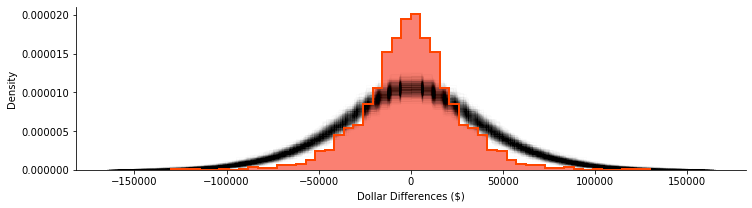

In [157]:
f = plt.figure(figsize=(12,3))
plt.hist(adjlist_wealth['diff'], 
         color='salmon', bins=50, density=True,
         alpha=1, linewidth=4)
[plt.hist(simulation, histtype='step', 
         color='k', alpha=.01, linewidth=1, 
         bins=50, density=True) for simulation in simulated_diffs.T]
plt.hist(adjlist_wealth['diff'], histtype='step', 
         edgecolor='orangered', bins=50, density=True,
         linewidth=2)
seaborn.despine()
plt.ylabel("Density")
plt.xlabel("Dollar Differences ($)")
plt.show()

Again, our random distribution is much more dispersed than our observed distribution of the differences between nearby tracts. Empirically, we can pool our simulations and construct and use their quantiles to summarize how unlikely any of our *observed* differences are if neighbors' household incomes were randomly assigned:

In [158]:
pooled_diffs = simulated_diffs.flatten()
lower, median, upper = numpy.percentile(pooled_diffs, q=(.5,50,99.5))
outside = (adjlist_wealth['diff'] < lower) | (adjlist_wealth['diff'] > upper)

So, despite the fact that that our observed differences are less dispersed on average, we can identify three boundaries in the data that are in the top 1% most extreme differences in neighboring household incomes across the map. These boundaries are shown in the table below:

In [159]:
adjlist_wealth[outside]

,focal,neighbor,weight,Median HH_focal,Median HH_neighbor,diff
736,142,148,1.0,41250.0,171094.0,-129844.0
767,148,180,1.0,171094.0,49050.0,122044.0
770,148,142,1.0,171094.0,41250.0,129844.0
933,180,148,1.0,49050.0,171094.0,-122044.0
1131,217,219,1.0,53173.0,168167.0,-114994.0
1144,219,217,1.0,168167.0,53173.0,114994.0


Note that one of these, observation $148$, appears in both boundaries. This means that the observation is likely to be *outlying*, extremely unlike *all* of its neighbors. These kinds of generalized neighborhood comparisons are discussed in the subsequent chapter on Local Spatial autocorrelation.

It is most helpful, though, to visualize this on a map, focusing on the first two boundaries around observation $148$, and then the second boundary between observation $217$ and $219$, shown in the larger context of San Diego incomes:

[-13068503.404883943,
 -13006196.85363941,
 3857713.0707310555,
 3903955.682213868]

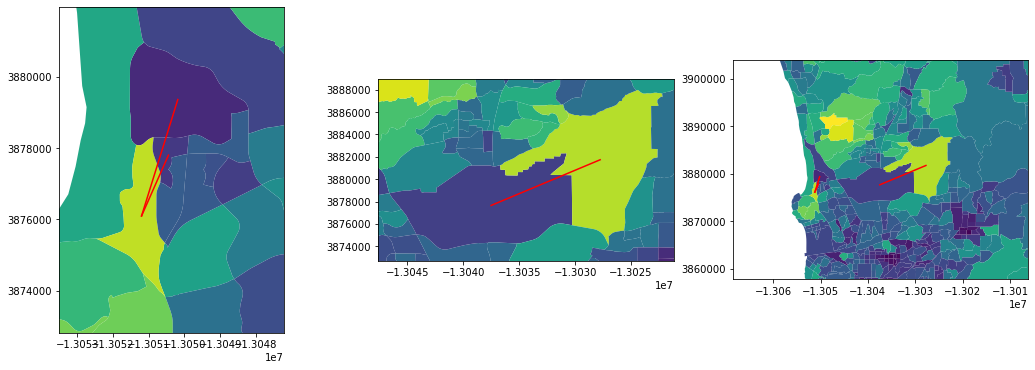

In [160]:
f,ax = plt.subplots(1,3,figsize=(18,6), 
                    subplot_kw=dict(aspect='equal'))
for i in range(3):
    san_diego_tracts.plot('Median HH', ax=ax[i])
first_focus = san_diego_tracts.iloc[[148,142]]
ax[0].plot(first_focus.centroid.x, first_focus.centroid.y, color='red')
ax[2].plot(first_focus.centroid.x, first_focus.centroid.y, color='red')
west,east,south,north = first_focus.buffer(1000).total_bounds
ax[0].axis([west, south, east, north])

second_focus = san_diego_tracts.iloc[[148,180]]
ax[0].plot(second_focus.centroid.x, second_focus.centroid.y, color='red')
ax[2].plot(second_focus.centroid.x, second_focus.centroid.y, color='red')

third_focus = san_diego_tracts.iloc[[217, 219]]
ax[1].plot(third_focus.centroid.x, third_focus.centroid.y, color='red')
ax[2].plot(third_focus.centroid.x, third_focus.centroid.y, color='red')
west,east,south,north = third_focus.buffer(1000).total_bounds
ax[1].axis([west, south, east, north])

area_of_focus = pandas.concat((first_focus, second_focus, third_focus)).buffer(16000).total_bounds
west, east, south, north = area_of_focus
ax[2].axis([west, south, east, north])

These are the starkest contrasts in the map, and result in the most distinctive divisions between adjacent tracts' household incomes. 

## Questions

1. Rook contiguity & Queen contiguity are two of three kinds of contiguity that are defined in terms of chess analogies. The third kind, *Bishop contiguity*, applies when two observations are considered connected when they share single vertices, but are considered *disconnected* if they share an edge. This means that observations that exhibit Queen contiguity are those that exhibit either Rook or Bishop contiguity. Using the Rook and Queen contiguity matrices we built for San Diego and the `Wsets.w_difference` function, are there any Bishop-contiguous observations in San Diego? 

2. Different kinds of spatial weights objects can result in very different kinds of graph structures. Considering the `cardinalities` of the Queen, Block, and union of Queen & Block, which graph type has the highest average cardinality? Why might this be the case? Which graph has more nonzero entries?

3. Comparing their average cardinality and percentage of nonzero links, which graph in this chapter has the *most sparse* structure? That is, which graph is the most sparsely connected?

4. In this chapter, we worked with regular *square* lattices using the `lat2W` function. In the same manner, the `hexLat2W` function can generate *hexagonal regular lattices*. For lattices of size (3,3), (6,6), and (9,9) for Rook & Queen `lat2W`, as well as for `hexLat2W`:

    1. examine the average cardinality. Does `lat2W` or `hexLat2W` have higher average cardinality? 
    2. Further, make a histogram of the cardinalities. Which type of lattice has higher variation in its number of neighbors? 
    3. Why is there no `rook=True` option in `hexLat2W`, as there is in `lat2W`?

5. The *Voronoi diagram* is a common method to construct polygons from a point dataset. A Voronoi diagram is built up from *Voronoi cells*, each of which contains the area that is closer to its source point than any other source point in the diagram. Further, the Queen contiguity graph for a *Voronoi diagram* obeys a number of useful properties, since it is the *Delaunay Triangulation* of a set of points. 
    1. Using the following code, build and plot the voronoi diagram for the *centroids* of Mexican states, with the states and their centroids overlayed:
    ```python
    from pysal.lib.weights.distance import get_points_array
    from pysal.lib.cg import voronoi_frames
    
    centroid_coordinates = get_points_array(mx.centroid)
    cells, centers = voronoi_frames(centroid_coordinates)
    
    ax = cells.plot(facecolor='none', edgecolor='k')
    mx.plot(ax=ax, edgecolor='red', facecolor='whitesmoke', alpha=.5)
    mx.centroid.plot(ax=ax,color='red', alpha=.5, markersize=10)
    ax.axis(mx.total_bounds[[0,2,1,3]])
    plt.show()
    ```
    2. Using the `weights.Voronoi` function, build the Voronoi weights for the Mexico states data.
    3. Compare the connections in the Voronoi and Queen weights for the Mexico states data. Which form is more connected? 
    4. Make a plot of the Queen contiguity and Voronoi contiguity graphs to compare them visually, like we did with the block weights & Queen weights. How do the two graphs compare in terms of the length of their links and how they connect the Mexican states?
    5. Using `weights.set_operations`, find any links that are in the Voronoi contiguity graph, but not in the Queen contiguity graph. Alternatively, find any links that are in the Queen contiguity graph, but not the Voronoi contiguity graph. 

6. Interoperability is important for the Python scientific stack. Thanks to standardization around the `numpy` array and the `scipy.sparse` array datastructures, it is simple and computationally-easy to convert objects from one representation to another:
    1. Using `w.to_networkx()`, convert the Mexico Regions Queen+Block weights matrix to a `networkx` graph. Compute the Eigenvector Centrality of that new object using `networkx.eigenvector_centrality`
    2. Using `w.sparse`, compute the number of connected components in the Mexico Regions Block weights matrix using the `connected_components` function in `scipy.sparse.csgraph`. 
    3. Using `w.sparse`, compute the all-pairs shortest path matrix in the Mexico Queen weights matrix using the `shortest_path` function in `scipy.sparse.csgraph`. 
    
7. While every node in a $k$-nearest neighbor graph has 5 neighbors, there is a conceptual difference between *indegree* and *outdegree* of nodes in a graph. The *outdegree* of a node is the number of outgoing links from a node; for a K-Nearest Neighbor graph, this is $k$ for every variable. The *indegree* of a node in a graph is the number of *incoming* links to that node; for a K-Nearest Neighbor graph, this is the number of other observations that pick the target as their nearest neighbor. The *indegree* of a node in the K-Nearest Neighbor graph can provide a measure of *hubbiness*, or how central a node is to other nodes. 
    1. Using the San Diego Tracts data, build a $k=6$ nearest neighbor weight and call it `knn_6`. 
    2. Verify that the $k=6$ by taking the row sum over the weights matrix in `knn_6.sparse`.
    3. Compute the indegree of each observation by taking the *column sum* over the weights matrix in `knn_6.sparse`, and divide by 6, the outdegree for all observations. 
    4. Make a histogram of the indegrees for the $k=6$ weights. How evenly-distributed is the distribution of indegrees?
    5. Make a new histogram of the indegree standardized by the outdegree when $k=26$. Does hubbiness reduce when increasing the number of $k$-nearest neighbors?

8. Sometimes, graphs are not simple to construct. For the `san_diego_neighborhoods` dataset:
    1. Build the Queen contiguity weights, and plot the graph on top of the neighborhoods themselves. How many connected components does this Queen contiguity graph have? 
    2. Build the K-Nearest Neighbor graph for the default, $k=2$. How many connected components does this K-Nearest Neighbor graph have? 
    3. What is the smallest $k$ that you can find for the K-Nearest Neighbor graph to be fully-connected?
    4. In graph theory, a link whose *removal* will increase the number of connected components in a graph is called a *bridge*. In the fully-connected KNN graph with the smallest $k$, how many bridges are there between the north and south components? *(hint: use the plotting functionality)*
    5. What are the next two values of $k$ required for there to be an *additional* bridge at that $k$?

## References

[1] Tobler, W. R. "A computer movie simulating urban growth in the Detroit region." *Economic Geography* 46, no. sup1 (1970): 234-240.

[2] Lu, H, and Carlin, B. 2005. “Bayesian Areal Wombling for Geographical Boundary Analysis.” *Geographical Analysis* 37 (3): 265–285.

[3] Fitzpatrick, M C.,Preisser, E.L., Porter, A., Elkinton, J., Waller, L.A., Carlin, B. P., and Ellison, A.M. 2010. “Ecological Boundary Detection Using Bayesian Areal Wombling.” *Ecology* 91 (12): 3448–3455.

[4] Dean, N., Dong, G., and Price, G. "Frontiers in Residential Segregation: Understanding Neighbourhood Boundaries and their Impacts." *Tijdschrift voor economische en sociale geografie*, in press

## Further Reading

LeSage, James P., and R. Kelley Pace. 2014. “The Biggest Myth in Spatial Econometrics.” *Econometrics* 2(4): 217–49. https://doi.org/10.3390/econometrics2040217.

Griffith, D. A. 1996. “Some Guidelines for Specifying the Geographic Weights Matrix Contained in Spatial Statistical Models.” In *Practical Handbook of Spatial Statistics*, edited by Sandra Lach Arlinghaus, 65–82. Boca Raton, FL: CRC Press.


---

<a rel="license" href="http://creativecommons.org/licenses/by-nc-nd/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-nc-nd/4.0/88x31.png" /></a><br />This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-nc-nd/4.0/">Creative Commons Attribution-NonCommercial-NoDerivatives 4.0 International License</a>.